# Imports

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import numpy.linalg
import scipy as sp
import scipy.signal
from sympy import symbols, lambdify
from sympy.matrices import *
from sympy.solvers import solve
import cv2 as cv2
import glob
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# Motion Model

### Continuous

In [3]:
def continuous():
    A = np.array(([0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0]))

    b = np.array(([0],
              [0],
              [0],
              [0],
              [1],
              [0],))

    C = 0

    d = 0
    return A, b, C, d

### Discretise

In [4]:
def discritise(frame_rate):
    A, b, C, d = continuous()
    T = 1/frame_rate
    F, g, C, d, T = sp.signal.cont2discrete((A, b, C, d), T)
    return F, g

### Process Noise

In [5]:
def process_noise(var):
    Rw = np.array(([var, 0, 0, 0, 0, 0],
                   [0, var, 0, 0, 0, 0],
                   [0, 0, var, 0, 0, 0],
                   [0, 0, 0, 5*var, 0, 0],
                   [0, 0, 0, 0, 5*var, 0],
                   [0, 0, 0, 0, 0, 5*var]))
    return Rw

# Measurement Model

### Non-linear

#### Symbolic non-linear function

In [6]:
def nonlinear_symbolic(K1, K2, Rt):
    K1 = Matrix(K1)
    K2 = Matrix(K2)
    Rt = Matrix(Rt)
    X, Y, Z = symbols('X Y Z')
    
    K0 = K1.row_join(zeros(3,1))
    P_ = Matrix([X, Y, Z, 1])

    camera1 = K0*P_
    camera2 = K2*Rt*P_

    x1 = camera1[0,:]/camera1[2,:]
    y1 = camera1[1,:]/camera1[2,:]
    x2 = camera2[0,:]/camera2[2,:]
    y2 = camera2[1,:]/camera2[2,:]
    
    h = Matrix([x1, y1, x2, y2])
    
    return h

#### Non-linear function at a point

In [7]:
def nonlinear(P, h):
    X, Y, Z = symbols('X Y Z')
    f = lambdify((X, Y, Z), h, 'numpy')
    h_P = f(P[0], P[1], P[2])
    return h_P

### Linearise

#### Symbolic Jacobian

In [8]:
def jacobian_symbolic(h):
    X, Y, Z = symbols('X Y Z')
    P = Matrix([X, Y, Z])
    H = h.jacobian(P)
    H = H.row_join(zeros(4,3))
    return H

#### Jacobian at a point

In [9]:
def jacobian(P, H):
    X, Y, Z = symbols('X Y Z')
    f = lambdify((X, Y, Z), H, 'numpy')
    H_P = f(P[0], P[1], P[2])
    return H_P

### Measurement Noise

In [10]:
def measurement_noise(var):
    Rv =  np.array(([var, 0, 0, 0],
                    [0, var, 0, 0],
                    [0, 0, var, 0],
                    [0, 0, 0, var]))
    return Rv

# Extended Kalman Filter

In [30]:
class EKF:

    def __init__(self, F, g, h, H, Rw, Rv, u):
        self.F = F
        self.g = g
        self.h = h
        self.H = H
        self.Rw = Rw
        self.Rv = Rv
        self.u = u
    
    def run(self):
        return None

    def initialise(self, K1, K2, Rt, y_):
        fx1, fy1, cx1, cy1 = K1[0,0], K1[1,1], K1[0,2], K1[1,2]
        fx2, fy2, cx2, cy2 = K2[0,0], K2[1,1], K2[0,2], K2[1,2]
        R = Rt[0:3, 0:3]
        t = np.array(([Rt[0:3, 3]])).T

        Z = symbols('Z')
        Z2 = symbols('Z2')
        x1 = Z*(y_[0, 0]-cx1)/fx1
        y1 = Z*(y_[1, 0]-cy1)/fy1
        z1 = Z
        x2 = Z*(y_[2, 0]-cx2)/fx2
        y2 = Z*(y_[3, 0]-cy2)/fy2
        z2 = Z2
        R_ = Matrix(R)
        t_ = Matrix(t)
        camera1 = np.array(([x1], [y1], [z1]))
        camera2 = R_.T*(Matrix([x2, y2, z2]) - t_)
        x2 = camera2[0,0]
        y2 = camera2[1,0]
        z2 = camera2[2,0]
        p1 = solve(x2 - x1, Z2)
        p2 = solve(z2 - z1, Z2)
        z = solve(p2[0] - p1[0], Z)[0]
        x = z*(y_[0, 0]-cx1)/fx1
        y = z*(y_[1, 0]-cy1)/fy1
        
        sigma_hat = np.array(([500, 0, 0, 0, 0, 0],
                              [0, 500, 0, 0, 0, 0],
                              [0, 0, 800, 0, 0, 0],
                              [0, 0, 0, 1000, 0, 0],
                              [0, 0, 0, 0, 1000, 0],
                              [0, 0, 0, 0, 0, 1000]))
        mu_hat = np.array(([x], [y], [z], [0], [0], [0]), dtype='float')
        
        return mu_hat, sigma_hat
    
    def predict(self, mu_hat_minus1, sigma_hat_minus1):
        mu_bar = self.F.dot(mu_hat_minus1) + self.g*self.u
        sigma_bar = self.F.dot(sigma_hat_minus1).dot(self.F.T) + self.Rw
        
        return mu_bar, sigma_bar
        
    def measurement_update(self, mu_bar, sigma_bar, y):
        P = np.array((mu_bar[0,0], mu_bar[1,0], mu_bar[2,0]))
        h_ = nonlinear(P, self.h)
        H_ = jacobian(P, self.H)

        K = (sigma_bar.dot(H_.T)).dot(np.linalg.inv(H_.dot(sigma_bar).dot(H_.T) + self.Rv))
        mu_hat = mu_bar + K.dot(y - h_)
        sigma_hat = (np.identity(6) - K.dot(H_)).dot(sigma_bar)
        
        return mu_hat, sigma_hat

# Image Processing Functions

### Background Subtraction

#### Simple

In [12]:
class background_sub_simple:
    
    def __init__(self, background_samples):
        #background model initialisation
        self.background = background_samples[0]
        for i in range(0, len(background_samples)-1):
            self.background = cv2.addWeighted(self.background,(i+1)/(i+2),background_samples[i+1],1/(i+2),0)
    
    def get_background(self):
        #get background image
        return self.background
    
    def subtract(self, image):
        #background subtract an image
        background_subbed = cv2.absdiff(image, self.background)
        return background_subbed

#### Mixture of Gaussians

In [13]:
class background_sub_mog:
    def __init__(self, history):
        #mog2 object initialisation
        self.background_sub = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
        self.background_sub.setHistory(history)
        
    def get_background_subtractor(self):
        #get mog2 object
        return self.background_sub
    
    def subtract(self, image):
        #background subtract an image
        return self.background_sub.apply(image)

### Thresholding

In [14]:
def thresh(image, threshtype):     # threshtype 0 = standard, threshtype 1 = adaptive, threshtype 2 = otsu (default 0)
    if(threshtype == 1):
        image_threshed = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 39, -15)
    elif(threshtype == 2):
        ret, image_threshed = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    else:
        ret, image_threshed = cv2.threshold(image, 15, 255, cv2.THRESH_BINARY)
    return np.array(image_threshed)

### Smoothing

In [15]:
def smooth(image, filtertype):     # filtertype 0 = gaussian, filtertype 1 = median, filtertype 2 = bilateral (default 0)
    if(filtertype == 1):
        image_smoothed = cv2.medianBlur(image, 5)
    elif(filtertype == 2):
        image_smoothed = cv2.bilateralFilter(image, 9, 100, 100)
    else:
        image_smoothed = cv2.GaussianBlur(image, (5, 5), 0)
    return np.array(image_smoothed)

### Morphological Transformations

#### Erosion

In [16]:
def erode(image, kernel_size): 
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    image_eroded = cv2.erode(image, kernel, iterations = 1)
    return np.array(image_eroded)

#### Dilation

In [17]:
def dilate(image, kernel_size): 
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    image_dilated = cv2.dilate(image, kernel, iterations = 1)
    return np.array(image_dilated)

### Centre of Mass

In [18]:
def find_centre(image):
    cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    M = cv2.moments(cnts[0])
    if(M["m00"] != 0):
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
    else:
        cx = -10
        cy = -10
    return np.array(([cx, cy]))

## Image Processing Pipeline

In [19]:
def process_image(image, background_sub):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = smooth(image, 0)
    image = background_sub.subtract(image)
    image = erode(image, 5)
    image = dilate(image, 5)
    return image

# Camera Calibration

code from https://github.com/bvnayak/stereo_calibration/blob/master/camera_calibrate.py

In [20]:
class StereoCalibration(object):
    def __init__(self, filepath, squaresize_mm):
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS +
                         cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (cv2.TERM_CRITERIA_EPS +
                             cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self.objp = np.zeros((9*6, 3), np.float32)
        self.objp[:, :2] = squaresize_mm*np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = []  # 3d point in real world space
        self.imgpoints_l = []  # 2d points in image plane.
        self.imgpoints_r = []  # 2d points in image plane.

        self.cal_path = filepath
        self.read_images(self.cal_path)

    def read_images(self, cal_path):
        images_right = glob.glob(cal_path + '\RIGHT\*.png')
        images_left = glob.glob(cal_path + '\LEFT\*.png')
        images_left.sort()
        images_right.sort()
        
        for i, fname in enumerate(images_right):
            img_l = cv2.imread(images_left[i])
            img_r = cv2.imread(images_right[i])

            gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
            gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret_l, corners_l = cv2.findChessboardCorners(gray_l, (9, 6), None)
            ret_r, corners_r = cv2.findChessboardCorners(gray_r, (9, 6), None)

            # If found, add object points, image points (after refining them)
            self.objpoints.append(self.objp)

            if ret_l is True:
                rt = cv2.cornerSubPix(gray_l, corners_l, (11, 11), (-1, -1), self.criteria)
                self.imgpoints_l.append(corners_l)

                # Draw and display the corners
                #ret_l = cv2.drawChessboardCorners(img_l, (9, 6), corners_l, ret_l)
                #cv2.imshow(images_left[i], img_l)
                #cv2.waitKey(500)

            if ret_r is True:
                rt = cv2.cornerSubPix(gray_r, corners_r, (11, 11), (-1, -1), self.criteria)
                self.imgpoints_r.append(corners_r)

                # Draw and display the corners
                #ret_r = cv2.drawChessboardCorners(img_r, (9, 6), corners_r, ret_r)
                #cv2.imshow(images_right[i], img_r)
                #cv2.waitKey(500)    
            img_shape = gray_l.shape[::-1]
        print('Beginning Camera 1 Calibration')
        rt, self.M1, self.d1, self.r1, self.t1 = cv2.calibrateCamera(self.objpoints, self.imgpoints_l, img_shape, None, None)
        print('Beginning Camera 2 Calibration')
        rt, self.M2, self.d2, self.r2, self.t2 = cv2.calibrateCamera(self.objpoints, self.imgpoints_r, img_shape, None, None)
        print('Individual Calibration Done')
        self.camera_model = self.stereo_calibrate(img_shape)
        
    def stereo_calibrate(self, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5
        print('Beginning Stereo Calibration')
        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        print('Stereo Calibration Done')
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints, self.imgpoints_l,
            self.imgpoints_r, self.M1, self.d1, self.M2,
            self.d2, dims,
            criteria=stereocalib_criteria, flags=flags)

        print('Intrinsic_mtx_1', M1)
        print('dist_1', d1)
        print('Intrinsic_mtx_2', M2)
        print('dist_2', d2)
        print('R', R)
        print('T', T)
        print('E', E)
        print('F', F)

        # for i in range(len(self.r1)):
        #     print("--- pose[", i+1, "] ---")
        #     self.ext1, _ = cv2.Rodrigues(self.r1[i])
        #     self.ext2, _ = cv2.Rodrigues(self.r2[i])
        #     print('Ext1', self.ext1)
        #     print('Ext2', self.ext2)

        print('')

        camera_model = dict([('M1', M1), ('M2', M2), ('dist1', d1),
                            ('dist2', d2), ('rvecs1', self.r1),
                            ('rvecs2', self.r2), ('R', R), ('T', T),
                            ('E', E), ('F', F)])

        cv2.destroyAllWindows()
        return camera_model

In [21]:
calibrate = False
if(calibrate):
    #calibrate
    cal = StereoCalibration('Datasets\Calibration', 26.2)

    #re-projection error 1
    mean_error = 0
    for i in range(len(cal.objpoints)):
        imgpoints2, _ = cv2.projectPoints(cal.objpoints[i], cal.r1[i], cal.t1[i], cal.M1, cal.d1)
        error = cv2.norm(cal.imgpoints_l[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print("total error 1: ", mean_error/len(cal.objpoints))

    #re-projection error 2
    mean_error = 0
    for i in range(len(cal.objpoints)):
        imgpoints2, _ = cv2.projectPoints(cal.objpoints[i], cal.r2[i], cal.t2[i], cal.M2, cal.d2)
        error = cv2.norm(cal.imgpoints_r[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    print("total error 2: ", mean_error/len(cal.objpoints))

### Calibration Results

$\text{Intrinsic matrix 1} =
\left(\begin{array}{cc} 
1193.02255 & 0 & 384.66449\\
0 & 1068.949 & 231.301996\\
0 & 0 & 1
\end{array}\right)$


$\text{Distortion coefficients 1} =
\left(\begin{array}{cc} 
-0.440069866 & 0.796985196 & -0.00009836159 & 0.000253569051 & -2.63555539
\end{array}\right)$


$\text{Intrinsic matrix 2} =
\left(\begin{array}{cc} 
1148.65035 & 0 & 331.26286\\
0 & 1029.03804 & 230.76246\\
0 & 0 & 1
\end{array}\right)$


$\text{Distortion coefficients 2} =
\left(\begin{array}{cc} 
-0.48730662 & 0.31067975 & 0.00165049 & 0.00251773 & -0.19269469
\end{array}\right)$


$\mathbf{R} = 
\left(\begin{array}{cc} 
0.96144265 & 0.0143581 & 0.27463045\\
-0.00473328 & 0.99935216 & -0.03567709\\
-0.27496479 & 0.03300158 & 0.96088775
\end{array}\right)$


$\mathbf{T} = 
\left(\begin{array}{cc} 
-218.70691767\\
3.94684443\\
83.88122482
\end{array}\right)$


$\mathbf{E} = 
\left(\begin{array}{cc} 
-0.68820981 & -83.69663118 & 6.7851127\\
20.51028497 & 8.42204752 & 233.18913577\\
-2.75946318 & -218.62189991 & 6.71890333
\end{array}\right)$


$\mathbf{F} = 
\left(\begin{array}{cc} 
0.000000183942 & 0.0000249666172 & -0.00800912858\\
-0.00000611910872 & -0.00000280430877 & -0.0799966651\\
0.00219830122 & 0.0672854848 & 1
\end{array}\right)$

$\text{Re-projection error 1} = 0.037841570461321174 $

$\text{Re-projection error 2} = 0.038650726653198346 $

In [22]:
K1 = np.array(([1.19302255e+03, 0.00000000e+00, 3.84664490e+02],
               [0.00000000e+00, 1.06894900e+03, 2.31301996e+02],
               [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]))
              
K2 = np.array(([1.14865035e+03, 0.00000000e+00, 3.31262860e+02],
               [0.00000000e+00, 1.02903804e+03, 2.30762460e+02],
               [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]))
              
R = np.array(([ 0.96144265,  0.0143581 ,  0.27463045],
              [-0.00473328,  0.99935216, -0.03567709],
              [-0.27496479,  0.03300158,  0.96088775]))
             
t = np.array(([-218.70691767],
              [   3.94684443],
              [  83.88122482]))

dist1 = np.array(([-4.40069866e-01,  7.96985196e-01, -9.83615924e-05, 2.53569051e-04, -2.63555539e+00]))

dist2 = np.array(([-0.48730662,  0.31067975,  0.00165049,  0.00251773, -0.19269469]))

# Set-Up Functions

In [31]:
frame_rate = 60
Rt = np.concatenate((R, t), axis=1)

F, g = discritise(frame_rate)
h = nonlinear_symbolic(K1, K2, Rt)
H = jacobian_symbolic(h)
Rw = process_noise(100)
Rv = measurement_noise(7)

parameters = [F, g, h, H, Rw, Rv, K1, K2, Rt, dist1, dist2]

# Full System

In [110]:
def process_video(file, *parameters, display=True):
    
    #Parameters?
    Param = False
    if(len(parameters) > 0):
        parameters = parameters[0]
        Param = True
        
    #Capture source
    if(file is None):
        cap0 = cv2.VideoCapture(0)
        cap1 = cv2.VideoCapture(1)
    else:
        cap0 = cv2.VideoCapture('Datasets\Stereo Dataset\\'+str(file)+' C1.avi')
        cap1 = cv2.VideoCapture('Datasets\Stereo Dataset\\'+str(file)+' C2.avi')
        
    #Background sub create
    background_sub = background_sub_mog(10)
    
    #Kalman filter create
    mu_hat, sigma_hat, mu_bar, sigma_bar  = None, None, None, None
    mu_predict, mu_update = [], []
    updated_previous_timestep = False
    if(Param):
        ekf = EKF(parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], parameters[5], 9810)
    frame_number = 0

    #main loop
    while(True):
        # Capture both cameras frame-by-frame
        ret, frame0 = cap0.read()
        ret, frame1 = cap1.read()
        if(frame0 is None or frame1 is None):
            break
        if(frame_number == 0 and Param):
            h,  w = frame0.shape[:2]
            K1_new, roi = cv2.getOptimalNewCameraMatrix(parameters[6],parameters[9],(w,h),1,(w,h))
            K2_new, roi = cv2.getOptimalNewCameraMatrix(parameters[7],parameters[10],(w,h),1,(w,h))
            
        # Operations on both frames
        frame0_processed = process_image(frame0, background_sub)
        frame0_processed[420:450, 475:600] = 0
        frame0_processed[:, 690:720] = 0
        frame0_processed[:, 0:10] = 0
        if(Param):
            frame0_processed = cv2.undistort(frame0_processed, parameters[6], parameters[9], None, K1_new)
        centre0 = find_centre(frame0_processed)

        frame1_processed = process_image(frame1, background_sub)
        frame1_processed[370:395, 270:390] = 0
        frame1_processed[:, 700:720] = 0
        frame1_processed[:, 0:20] = 0
        if(Param):
            frame1_processed = cv2.undistort(frame1_processed, parameters[7], parameters[10], None, K2_new)
        centre1 = find_centre(frame1_processed)
        
        #Kalman filter
        if(Param):
            #Initialise
            if(frame_number > 20 and centre0[0] > 0 and centre1[0] > 0 and mu_hat is None):
                y=np.array(([centre0[0]],
                            [centre0[1]],
                            [centre1[0]],
                            [centre1[1]]))
                mu_hat, sigma_hat = ekf.initialise(parameters[6], parameters[7], parameters[8], y)
                mu_update.append(mu_hat)
                updated_previous_timestep = True
            #Update
            elif(centre0[0] > 0 and centre1[0] > 0 and mu_hat is not None):
                mu_bar, sigma_bar = ekf.predict(mu_hat, sigma_hat)
                mu_predict.append(mu_bar)
                y=np.array(([centre0[0]],
                            [centre0[1]],
                            [centre1[0]],
                            [centre1[1]]))
                mu_hat, sigma_hat = ekf.measurement_update(mu_bar, sigma_bar, y)
                mu_update.append(mu_hat)
                updated_previous_timestep = True
            elif(updated_previous_timestep):
                mu_bar, sigma_bar = ekf.predict(mu_hat, sigma_hat)
                mu_predict.append(mu_bar)
                updated_previous_timestep = False
        
        #Display
        if(display):
            frame0_processed = cv2.cvtColor(frame0_processed, cv2.COLOR_GRAY2BGR)
            frame1_processed = cv2.cvtColor(frame1_processed, cv2.COLOR_GRAY2BGR)
            
            if(Param):
                frame0 = cv2.undistort(frame0, K1, dist1, None, K1_new)
                frame1 = cv2.undistort(frame1, K2, dist2, None, K2_new)

            cv2.circle(frame0_processed, (centre0[0], centre0[1]), 4, (0 , 0, 255), -1)
            cv2.circle(frame0, (centre0[0], centre0[1]), 4, (0 , 0, 255), -1)

            cv2.circle(frame1_processed, (centre1[0], centre1[1]), 4, (0 , 0, 255), -1)
            cv2.circle(frame1, (centre1[0], centre1[1]), 4, (0 , 0, 255), -1)

            # Display the resulting frames
            horizontal_stack0 = np.hstack((frame0_processed, frame1_processed))
            horizontal_stack1 = np.hstack((frame0, frame1))
            vertical_stack = np.vstack((horizontal_stack0, horizontal_stack1))
            cv2.imshow('Press \'q\' to exit', vertical_stack)
        if cv2.waitKey(1) & 0xFF ==ord('q'):
            break
        frame_number += 1
        
    #Release the capture
    cap0.release()
    cap1.release()
    cv2.destroyAllWindows()
    
    if(Param):
        return mu_predict, mu_update
    else:
        return None

# Result Plotting

In [117]:
def plot_xy(x_predict, y_predict, x_update, y_update, x_fit, y_fit, file):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)

    ax.plot(x_predict, y_predict, c='blue')
    ax.plot(x_update, y_update, c='green')
    ax.plot(x_fit, y_fit, c='red')
    
    colors = np.arange(0, len(x_predict))
    ax.scatter(x_predict, y_predict, c=colors, marker='x', s = 150, cmap='jet')
    colors = np.arange(0, len(x_update))
    ax.scatter(x_update, y_update, c=colors, marker='D', s = 30, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(x_fit))
    ax.scatter(x_fit, y_fit, c=colors, s = 50, linewidths=1, edgecolor='black', cmap='jet')

    ax.set_title('EKF trajectory estimation in X-Y plane for dataset \"%s\"\n' %file, fontsize=18)
    ax.set_xlabel('X [mm]', fontsize=16)
    ax.set_ylabel('Y [mm]', fontsize=16)
    
    crosses = mlines.Line2D([], [], color='blue', marker='x', markersize=10, label='Prediction Estimate')
    diamonds = mlines.Line2D([], [], color='green', marker='D', markersize=7, label='Measurement Update Estimate')
    circles = mlines.Line2D([], [], color='red', marker='o', markersize=7, label='Best Fit Trajectory')
    ax.legend(handles=[crosses, diamonds, circles], loc='lower left', bbox_to_anchor=(0.27, 0), fontsize= 16)
    
    ax.set_xlim(np.min(x_update)-100, np.max(x_update)+100)
    ax.set_ylim(np.min(y_update)-50, np.max(y_update)+50)
    ax.grid(True)
    
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()
    
    fig.savefig("Results\Graphs\%s_XY.pdf" %file, bbox_inches='tight')

In [118]:
def plot_xz(x_predict, z_predict, x_update, z_update, x_fit, z_fit, file):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)

    ax.plot(x_predict, z_predict, c='blue')
    ax.plot(x_update, z_update, c='green')
    ax.plot(x_fit, z_fit, c='red')
    
    colors = np.arange(0, len(x_predict))
    ax.scatter(x_predict, z_predict, c=colors, marker='x', s = 150, cmap='jet')
    colors = np.arange(0, len(x_update))
    ax.scatter(x_update, z_update, c=colors, marker='D', s = 30, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(x_fit))
    ax.scatter(x_fit, z_fit, c=colors, s = 50, linewidths=1, edgecolor='black', cmap='jet')
    
    ax.set_title('EKF trajectory estimation in X-Z plane for dataset \"%s\"\n' %file, fontsize=18)
    ax.set_xlabel('X [mm]', fontsize=16)
    ax.set_ylabel('Z [mm]', fontsize=16)
    
    crosses = mlines.Line2D([], [], color='blue', marker='x', markersize=10, label='Prediction Estimate')
    diamonds = mlines.Line2D([], [], color='green', marker='D', markersize=7, label='Measurement Update Estimate')
    circles = mlines.Line2D([], [], color='red', marker='o', markersize=7, label='Best Fit Trajectory')
    ax.legend(handles=[crosses, diamonds, circles], loc='lower left', bbox_to_anchor=(0.27, 0), fontsize= 16)
    
    ax.set_xlim(np.min(x_update)-100, np.max(x_update)+100)
    ax.set_ylim(np.min(z_update)-200, np.max(z_update)+200)
    ax.grid(True)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.show()
    
    fig.savefig("Results\Graphs\%s_XZ.pdf" %file, bbox_inches='tight')

In [119]:
def plot_3d(x_predict, y_predict, z_predict, x_update, y_update, z_update, x_fit, y_fit, z_fit, file):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    #3D points
    ax.plot(np.array(x_predict), np.array(z_predict), np.array(y_predict), zdir='z', c='blue')
    ax.plot(np.array(x_update), np.array(z_update), np.array(y_update), zdir='z', c='green')
    ax.plot(np.array(x_fit), np.array(z_fit), np.array(y_fit), zdir='z', c='red')
    colors = np.arange(0, len(z_predict))
    ax.scatter(np.array(x_predict), np.array(z_predict), np.array(y_predict), zdir='z', c=colors, marker='x', s = 150, cmap='jet')
    colors = np.arange(0, len(z_update))
    ax.scatter(np.array(x_update), np.array(z_update), np.array(y_update), zdir='z', c=colors,
               marker='D', s = 30, linewidths=1, edgecolor='black', cmap='jet')
    colors = np.arange(0, len(z_fit))
    ax.scatter(np.array(x_fit), np.array(z_fit), np.array(y_fit), zdir='z', c=colors,
               s = 50, linewidths=1, edgecolor='black', cmap='jet')

    #2D projections
    y = np.full(len(y_predict), np.max(y_update)+150)

    ax.plot(np.array(x_predict), np.array(z_predict), y, zdir='z', c = 'black')
    colors = np.arange(0, len(z_predict))
    colors = colors[::-1]
    ax.scatter(np.array(x_predict), np.array(z_predict), y, zdir='z', c=colors, marker='x', s = 150, cmap=plt.cm.Greys)
    
    y = np.full(len(y_update), np.max(y_update)+150)
    
    ax.plot(np.array(x_update), np.array(z_update), y, zdir='z', c = 'black')
    colors = np.arange(0, len(z_update))
    colors = colors[::-1]
    ax.scatter(np.array(x_update), np.array(z_update), y, zdir='z', c=colors,
               marker='D', s = 30, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')
    
    y = np.full(len(y_fit), np.max(y_fit)+150)
    
    ax.plot(np.array(x_fit), np.array(z_fit), y, zdir='z', c = 'black')
    colors = np.arange(0, len(z_fit))
    colors = colors[::-1]
    ax.scatter(np.array(x_fit), np.array(z_fit), y, zdir='z', c=colors,
               s = 30, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')

    z = np.full(len(z_predict), np.max(z_update)+300)

    ax.plot(np.array(x_predict), z, np.array(y_predict), zdir='z', c = 'black')
    colors = np.arange(0, len(z_predict))
    colors = colors[::-1]
    ax.scatter(np.array(x_predict), z, np.array(y_predict), zdir='z', c=colors, marker='x', s = 150, cmap=plt.cm.Greys)
    
    z = np.full(len(z_update), np.max(z_update)+300)
    
    ax.plot(np.array(x_update), z, np.array(y_update), zdir='z', c = 'black')
    colors = np.arange(0, len(z_update))
    colors = colors[::-1]
    ax.scatter(np.array(x_update), z, np.array(y_update), zdir='z', c=colors,
               marker='D', s = 30, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')
    
    z = np.full(len(z_fit), np.max(z_fit)+300)
    
    ax.plot(np.array(x_fit), z, np.array(y_fit), zdir='z', c = 'black')
    colors = np.arange(0, len(z_update))
    colors = colors[::-1]
    ax.scatter(np.array(x_fit), z, np.array(y_fit), zdir='z', c=colors,
               s = 30, cmap=plt.cm.Greys, linewidths=1, edgecolor='black')

    ax.set_title('EKF trajectory estimation in 3-D space for dataset \"%s\"\n' %file, fontsize=18)
    ax.set_xlim(np.min(x_update)-50, np.max(x_update)+50)
    ax.set_ylim(np.min(z_update)-200, np.max(z_update)+300)
    ax.set_zlim(np.min(y_update)-50, np.max(y_update)+150)
    
    crosses = mlines.Line2D([], [], color='blue', marker='x', markersize=10, label='Prediction Estimate')
    diamonds = mlines.Line2D([], [], color='green', marker='D', markersize=7, label='Measurement Update Estimate')
    circles = mlines.Line2D([], [], color='red', marker='o', markersize=7, label='Best Fit Trajectory')
    ax.legend(handles=[crosses, diamonds, circles], loc='upper center', bbox_to_anchor=(0.5, 0), fontsize= 16)
    
    ax.set_xlabel('X [mm]', fontsize=16)
    ax.set_ylabel('Z [mm]', fontsize=16)
    ax.set_zlabel('Y [mm]', fontsize=16)

    plt.gca().invert_zaxis()
    
    plt.show()
    
    fig.savefig("Results\Graphs\%s_3D.pdf" %file, bbox_inches='tight')

# Tests

In [135]:
file = 'Ball21'
%time predict, update = process_video(file, parameters, display=True) 
#%time process_video('Ball2', display=True) 

Wall time: 8.62 s


mean predition error:	 48.701622 mm
max predition error:	 90.066022 mm
mean update error:	 40.795230 mm
max update error:	 74.292769 mm


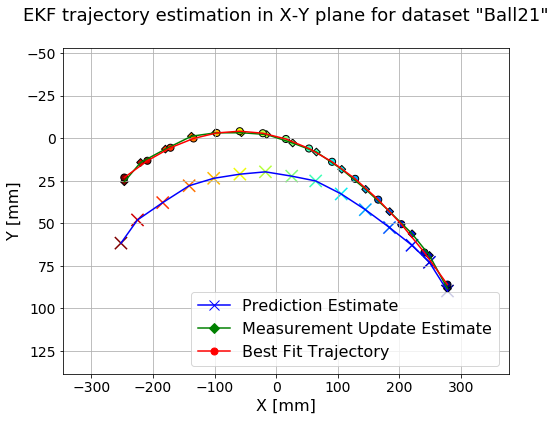

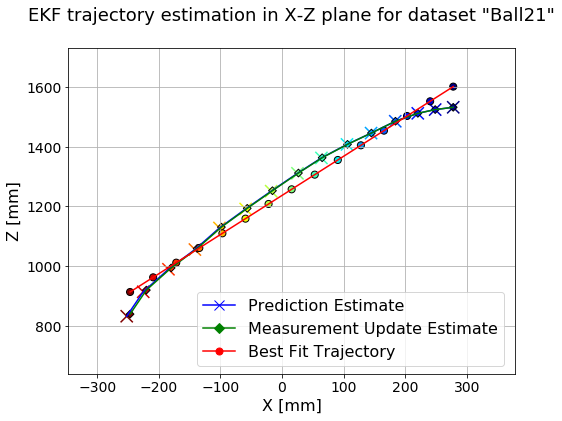

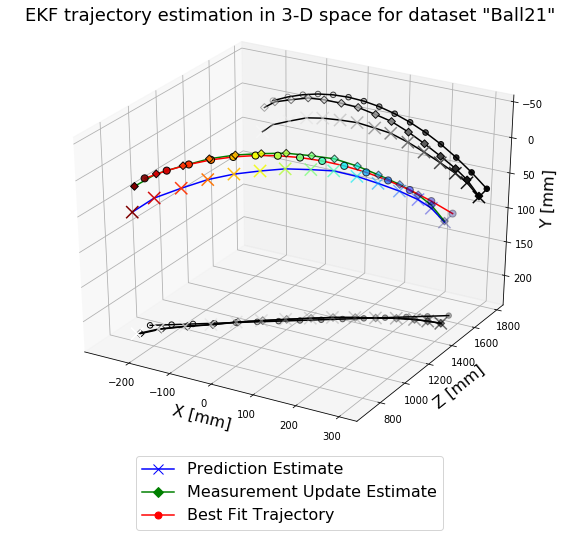

In [136]:
x_predict, y_predict, z_predict = [], [], []
x_update, y_update, z_update = [], [], []
for i in range(len(predict)):
    x_predict.append(predict[i][0,0])
    y_predict.append(predict[i][1,0])
    z_predict.append(predict[i][2,0])
for i in range(len(update)):
    x_update.append(update[i][0,0])
    y_update.append(update[i][1,0])
    z_update.append(update[i][2,0])
    
def f(x, A, B):
    return A*x + B
A, B = curve_fit(f, x_update, z_update)[0]
x_fit = np.linspace(np.min(x_update), np.max(x_update), len(update))
if(x_update[0] > 0 ):
    x_fit = np.linspace(np.max(x_update), np.min(x_update), len(update))
z_fit = A*x_fit + B

def f(x, A, B, C):
    return A*x**2 + B*x + C
A, B, C = curve_fit(f, x_update, y_update)[0]
y_fit = A*x_fit**2 + B*x_fit + C

points_predict, points_update, points_fit = [], [], []
for i in range(len(x_fit)):
    points_predict.append(np.array(([x_predict[i]], [y_predict[i]], [z_predict[i]])))
    points_update.append(np.array(([x_update[i]], [y_update[i]], [z_update[i]])))
    points_fit.append(np.array(([x_fit[i]], [y_fit[i]], [z_fit[i]])))
    
dist_predict, dist_update = [], []
for i in range(len(points_fit)):
    dist_predict.append(numpy.linalg.norm(points_predict[i] - points_fit[i]))
    dist_update.append(numpy.linalg.norm(points_update[i] - points_fit[i]))
print('mean predition error:\t %f mm'%np.mean(dist_predict))
print('max predition error:\t %f mm'%np.max(dist_predict))
print('mean update error:\t %f mm'%np.mean(dist_update))
print('max update error:\t %f mm'%np.max(dist_update))

plot_xy(x_predict, y_predict, x_update, y_update, x_fit, y_fit, file)
plot_xz(x_predict, z_predict, x_update, z_update, x_fit, z_fit, file)
plot_3d(x_predict, y_predict, z_predict, x_update, y_update, z_update, x_fit, y_fit, z_fit, file)

### All Plots

#### Ball

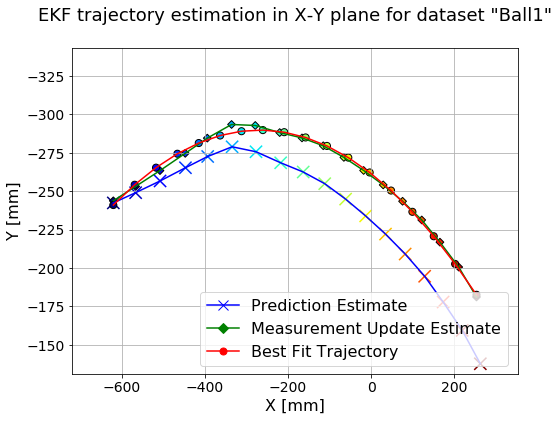

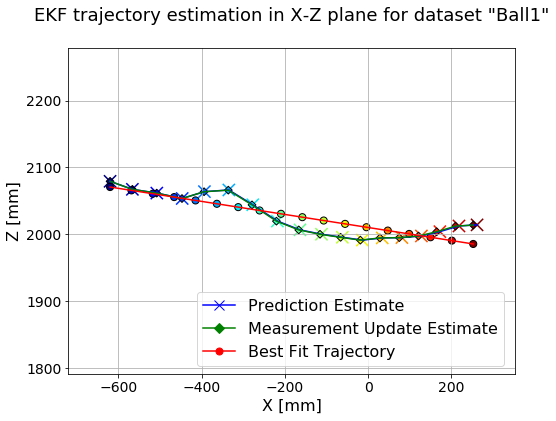

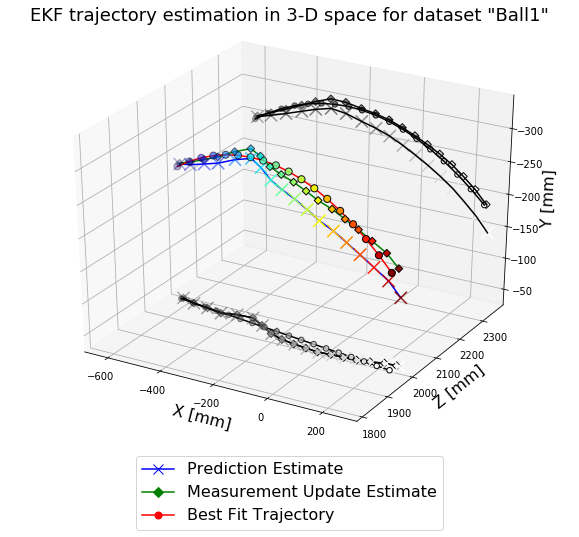

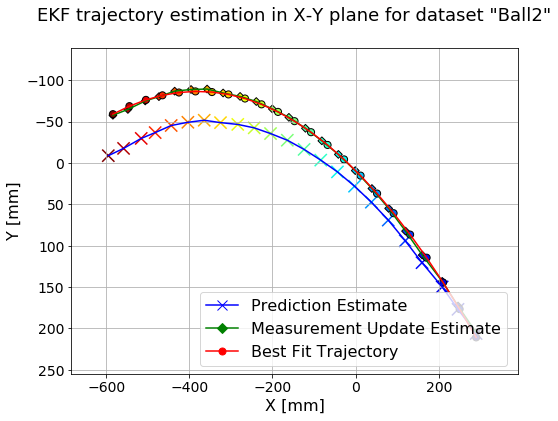

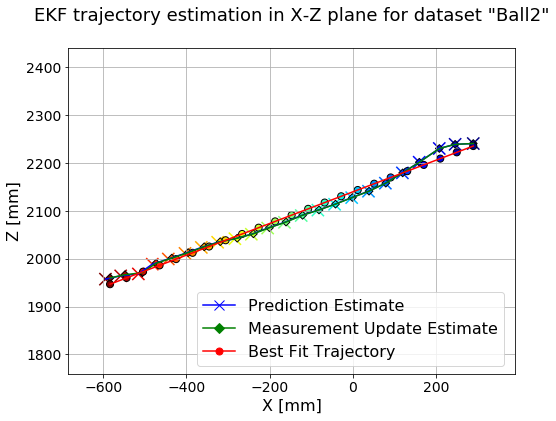

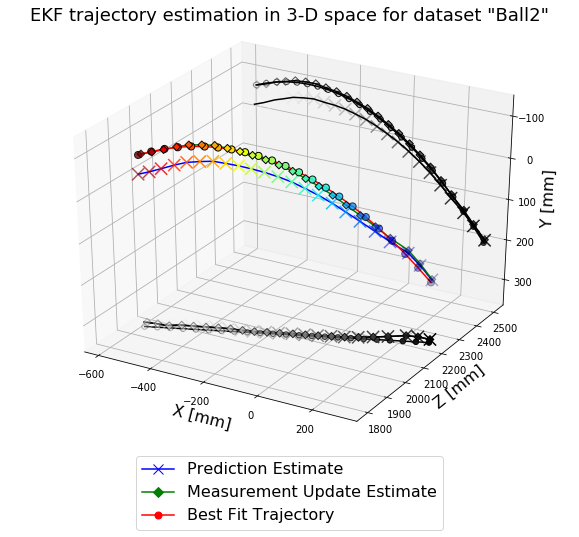

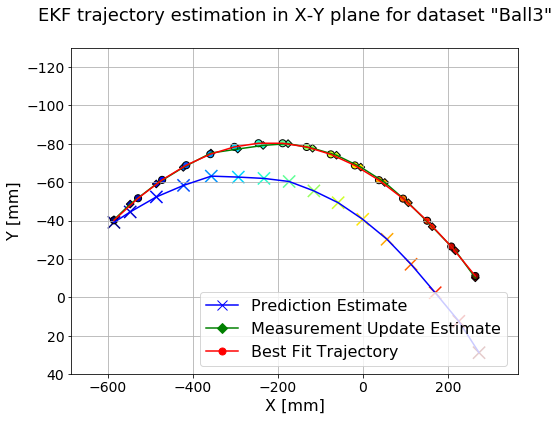

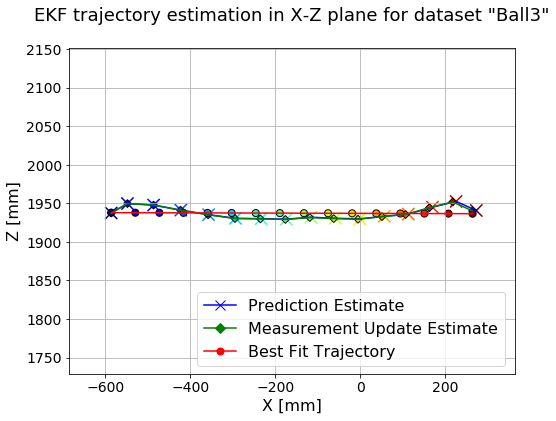

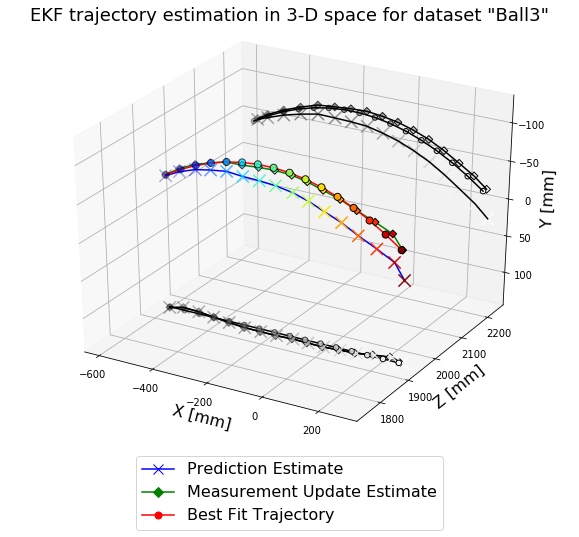

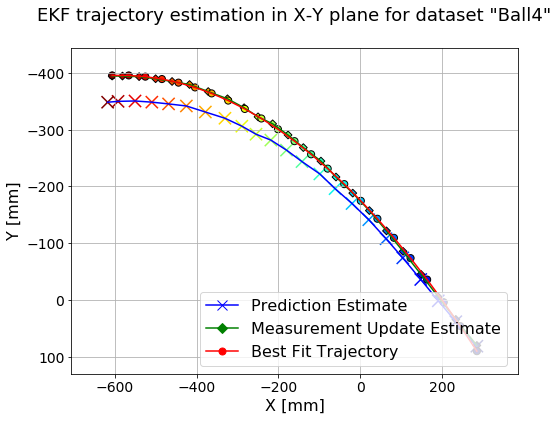

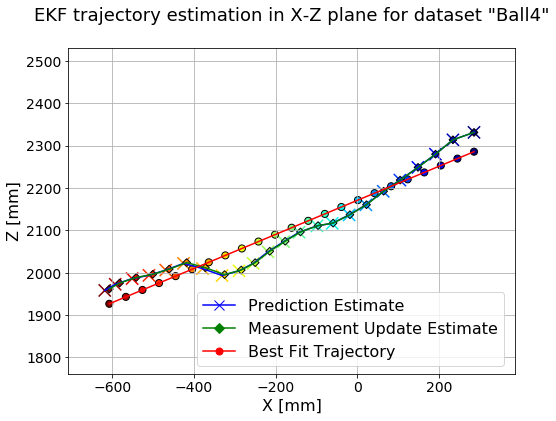

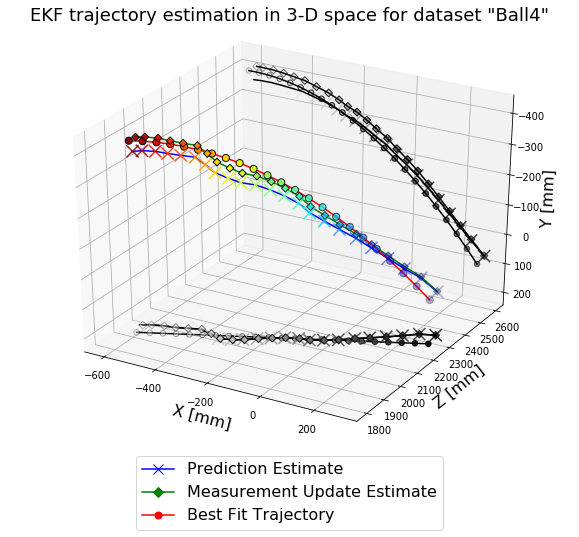

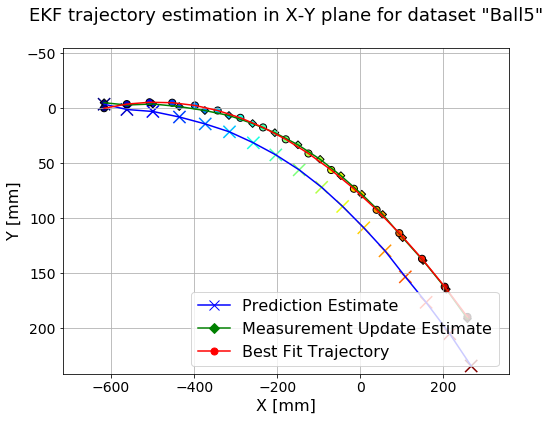

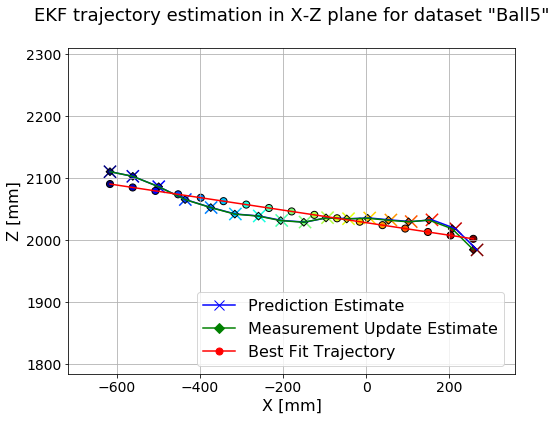

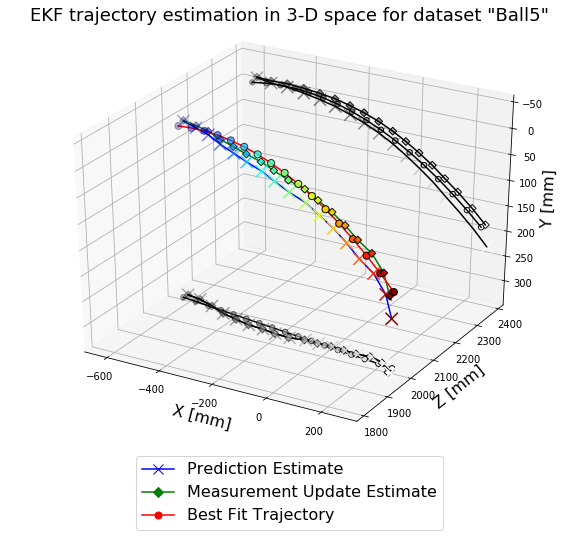

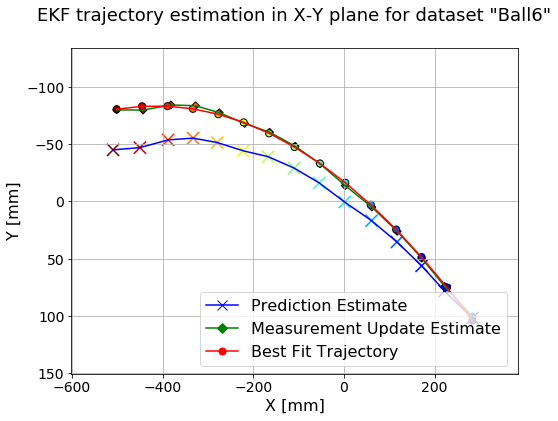

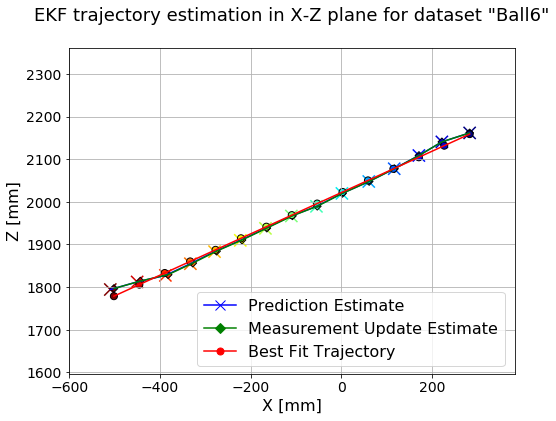

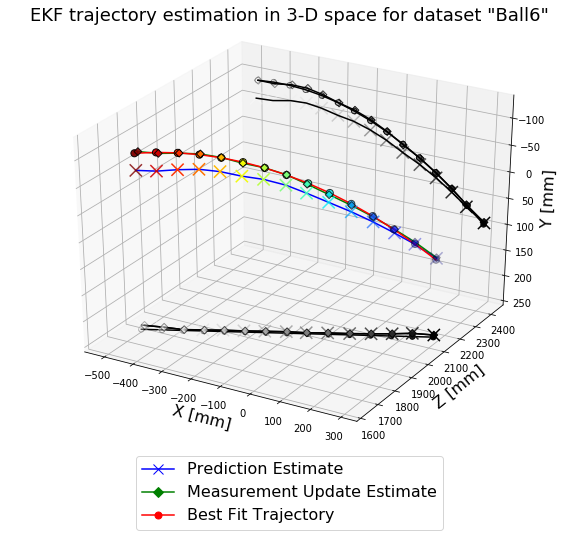

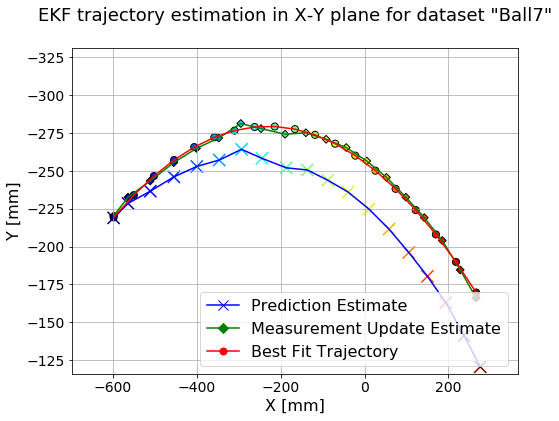

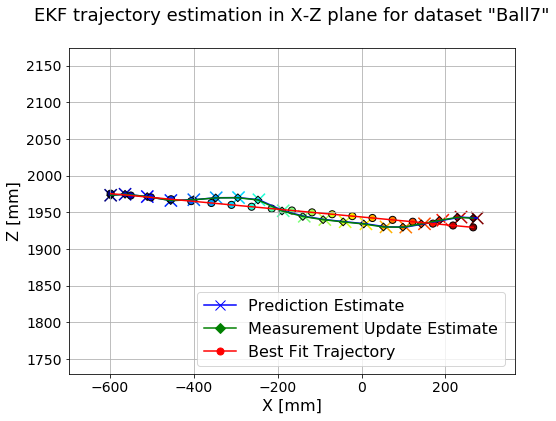

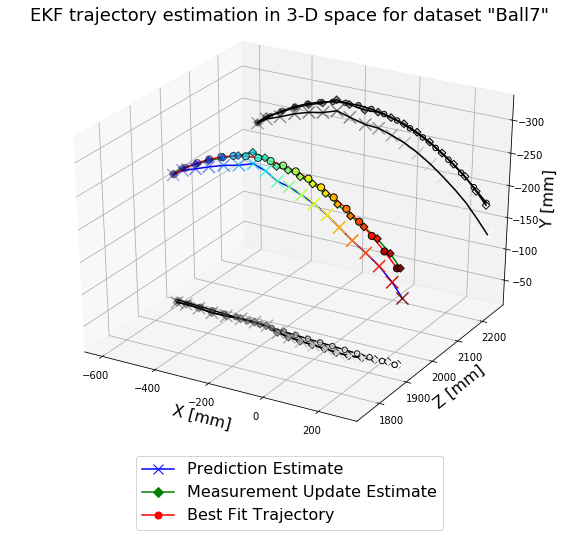

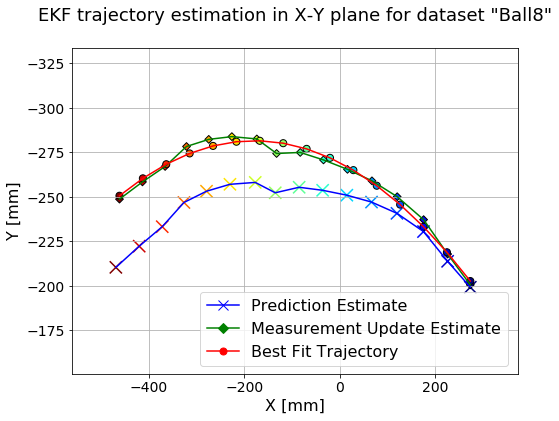

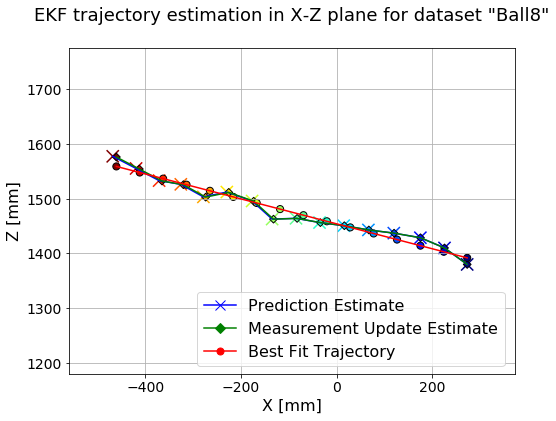

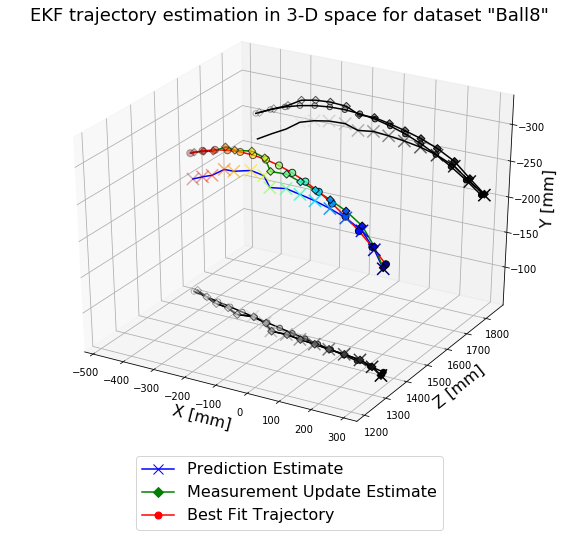

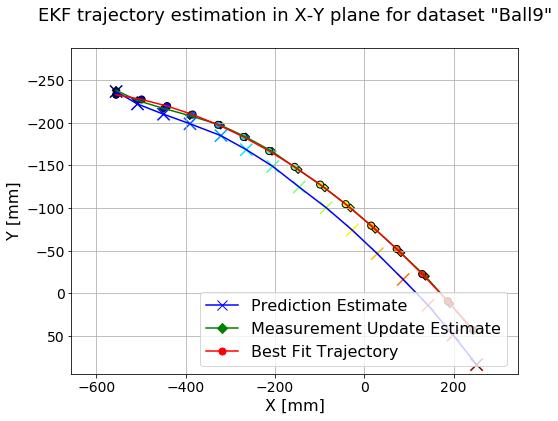

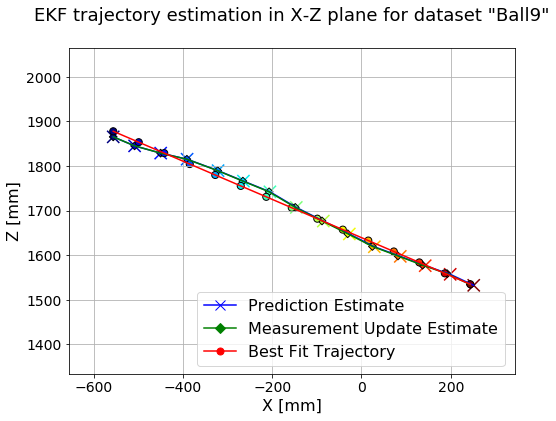

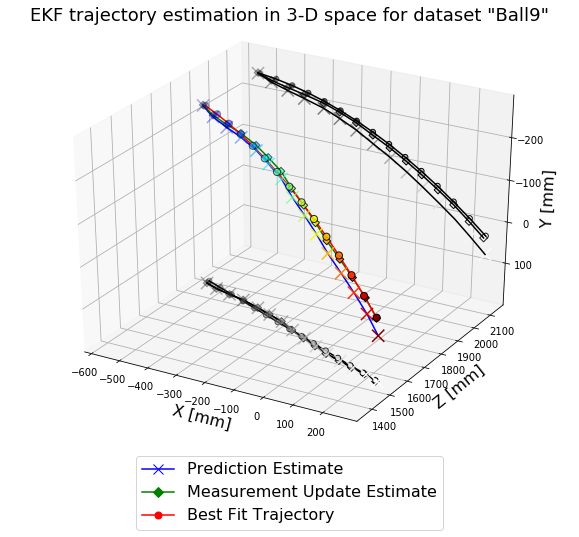

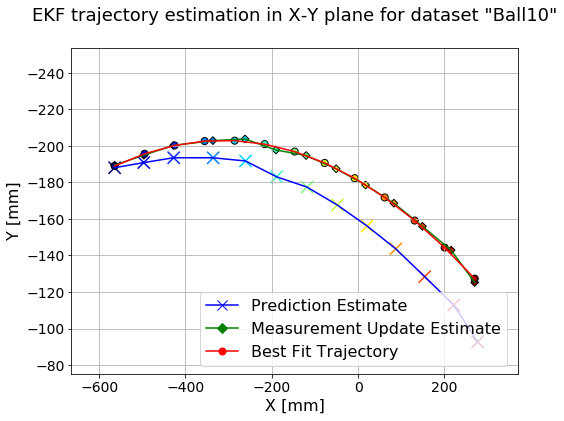

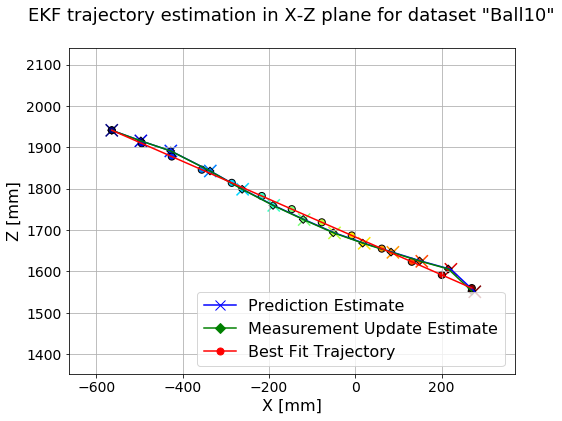

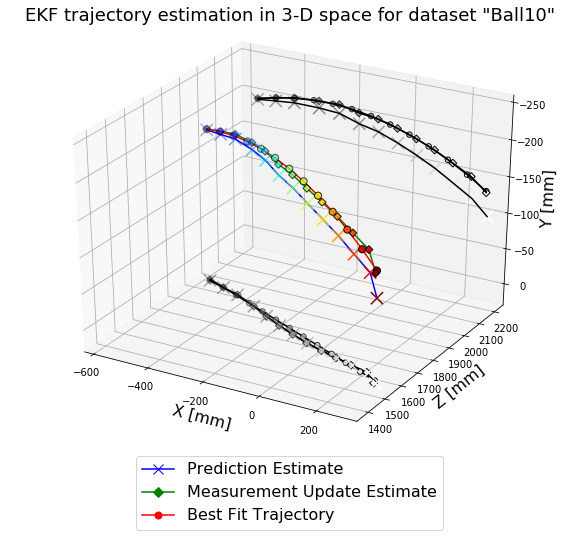

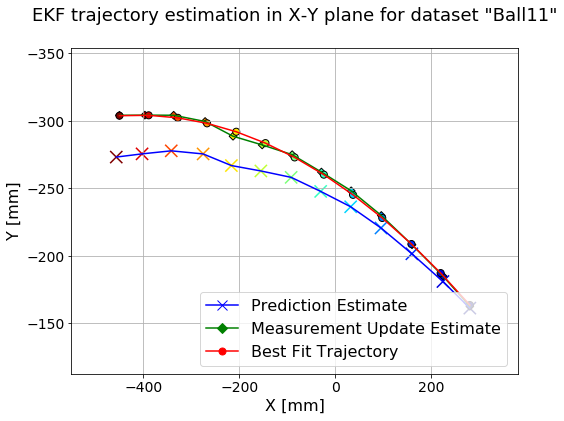

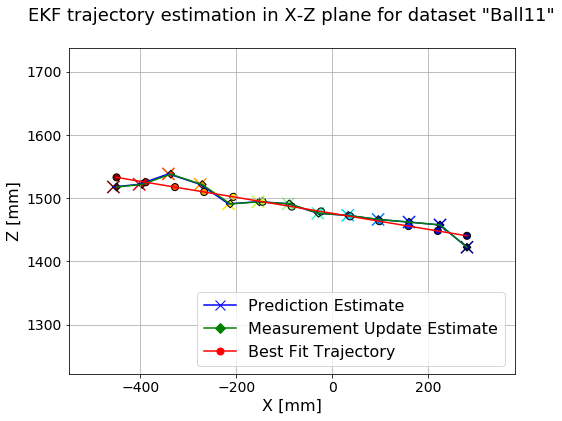

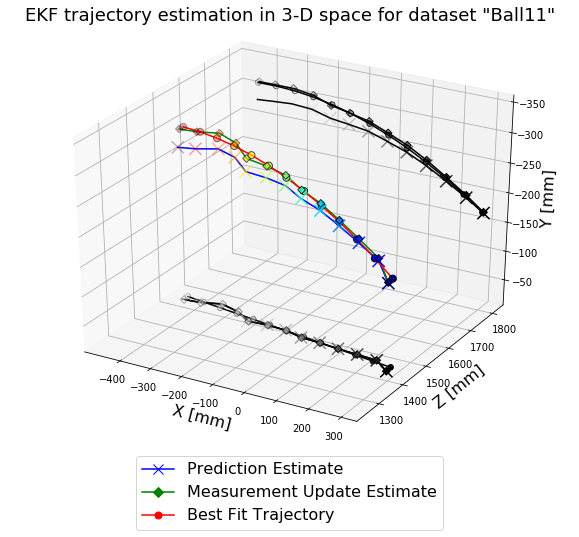

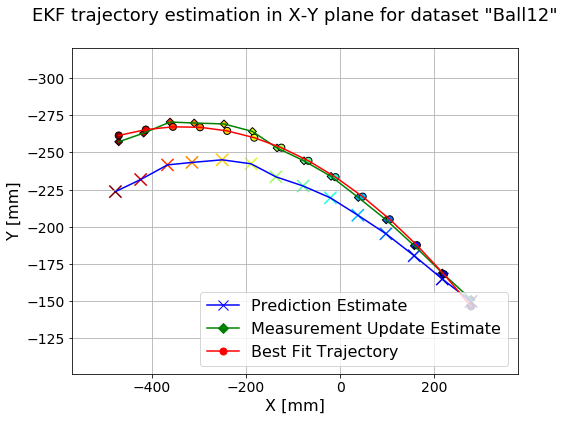

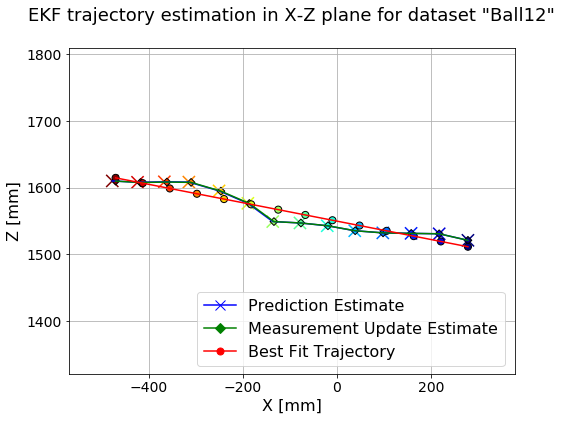

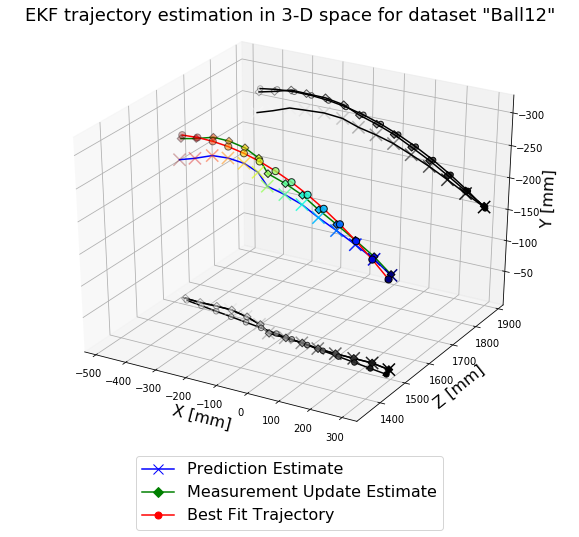

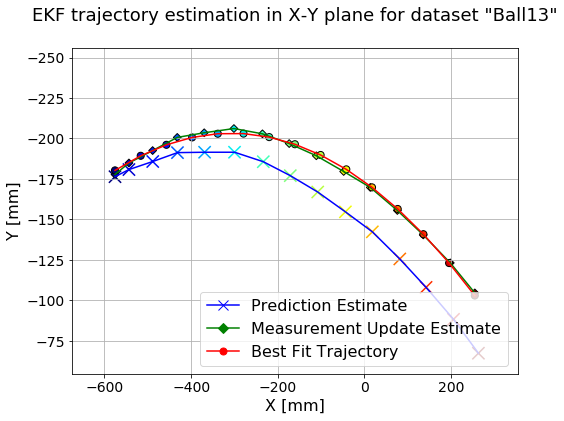

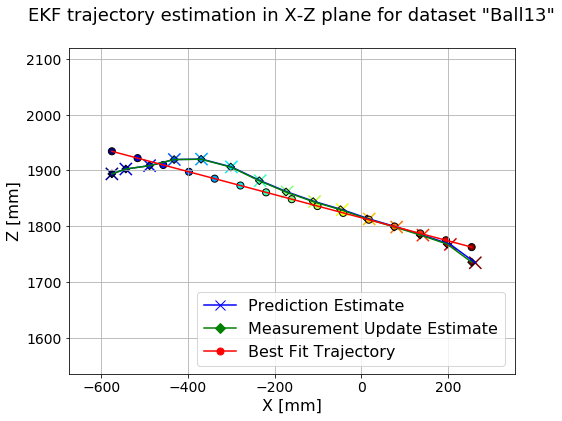

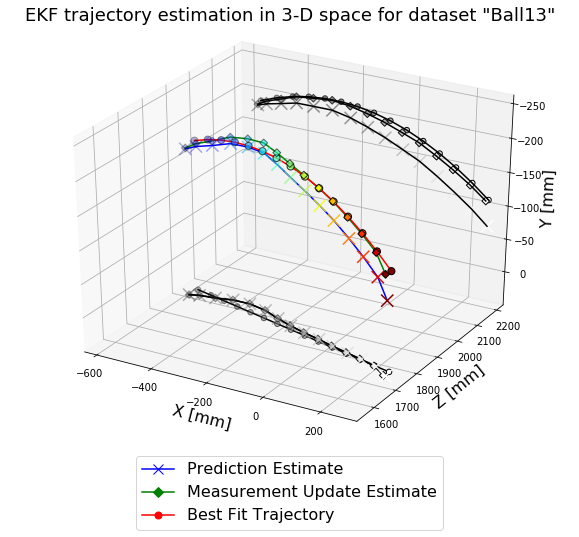

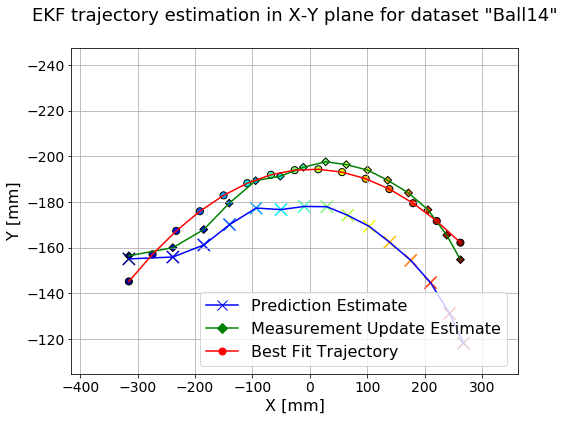

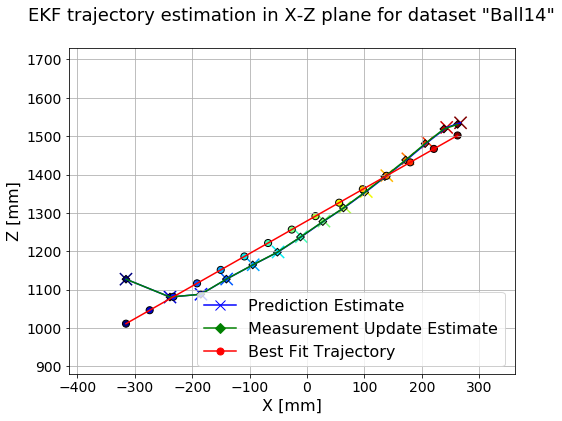

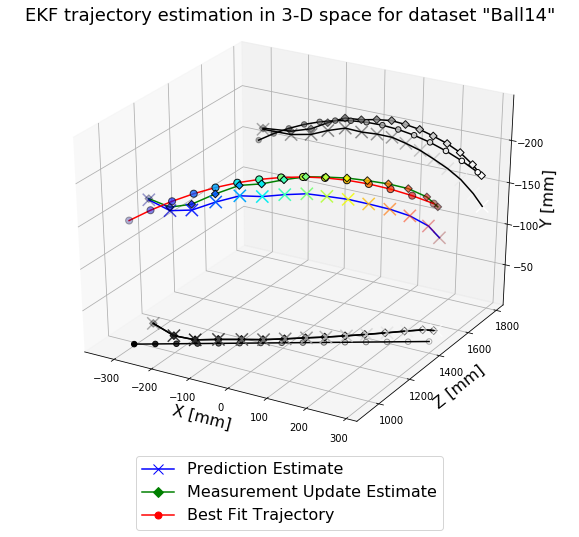

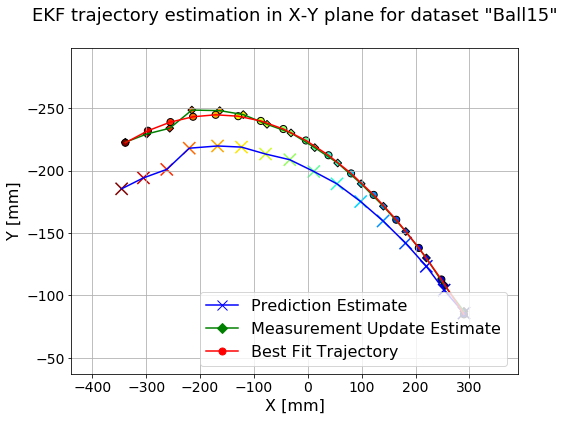

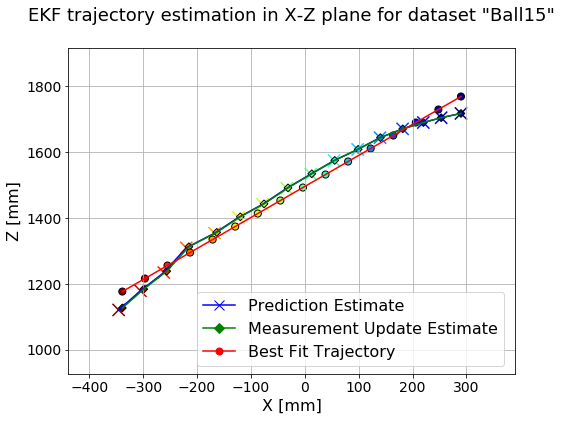

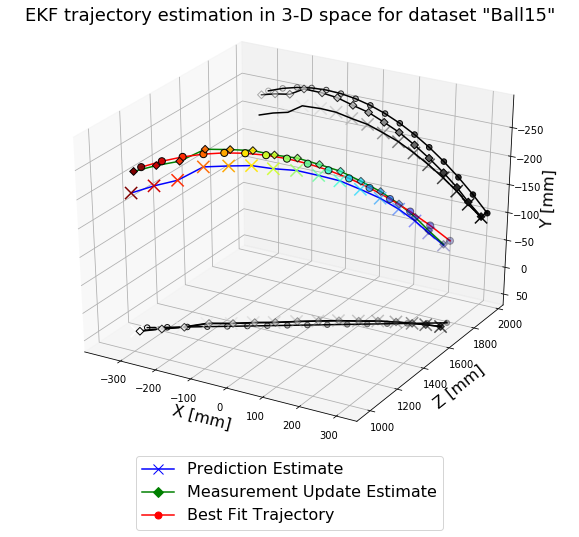

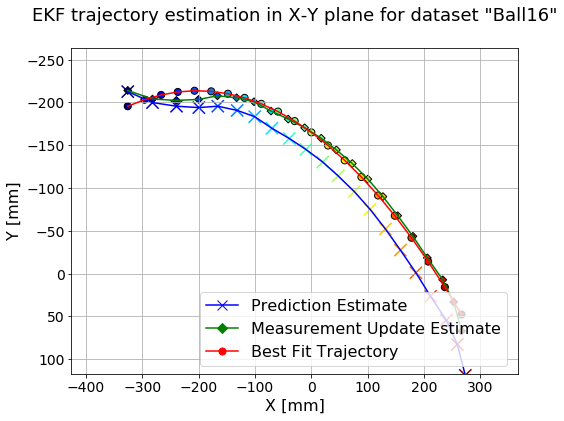

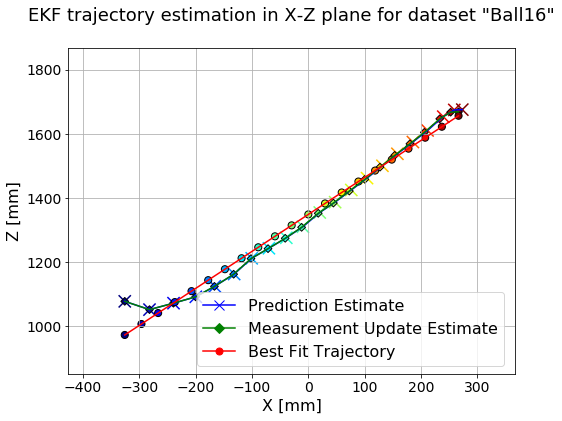

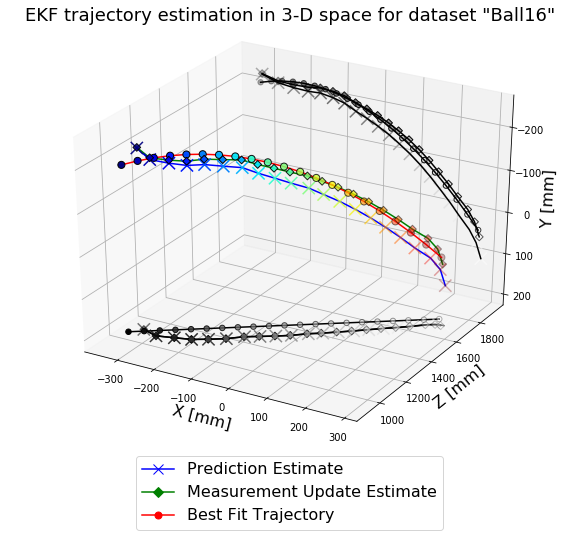

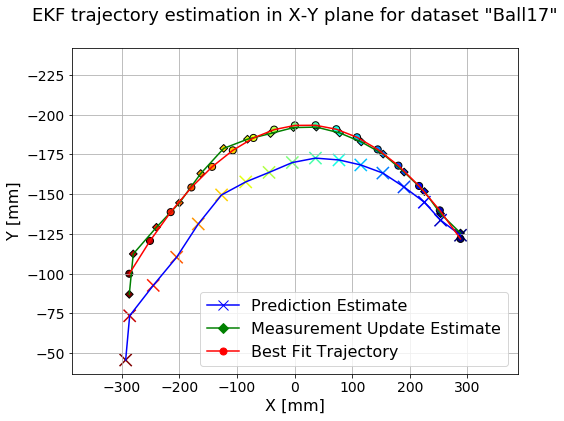

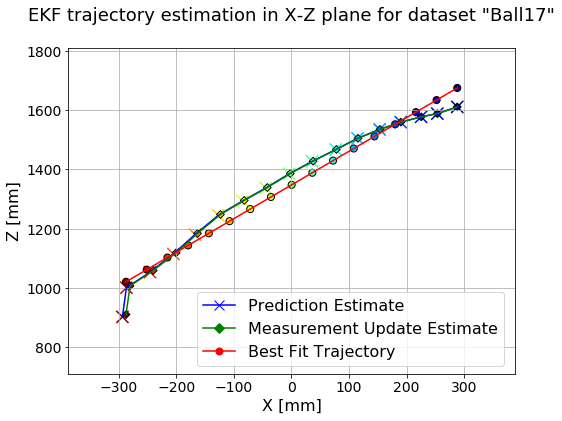

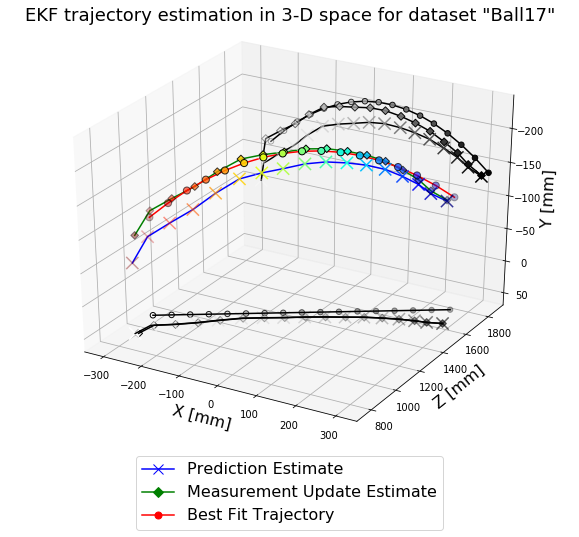

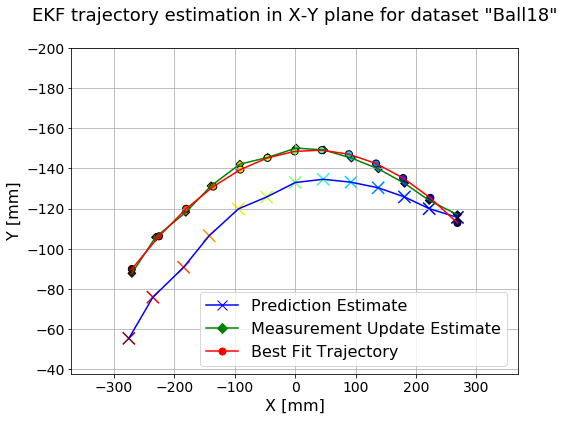

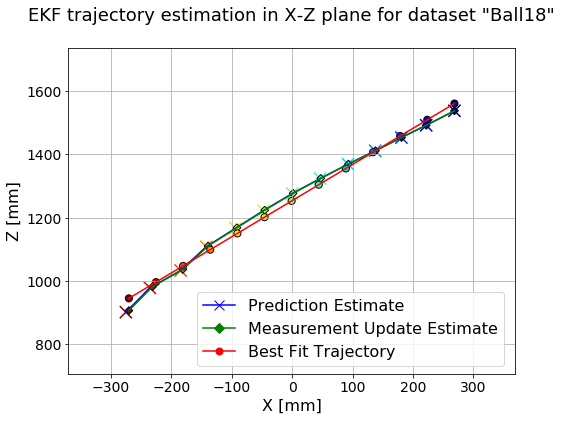

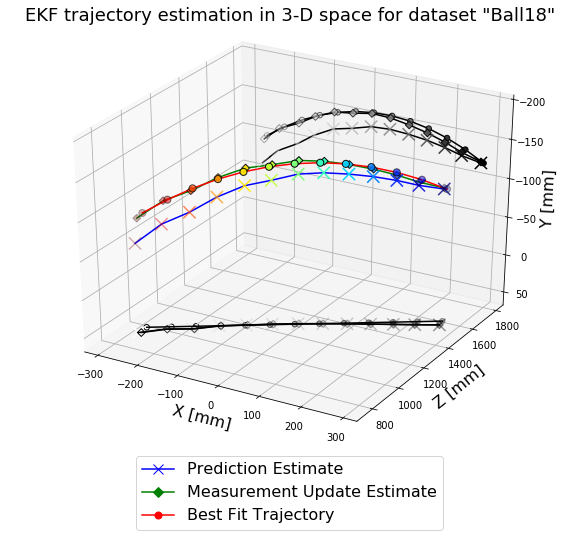

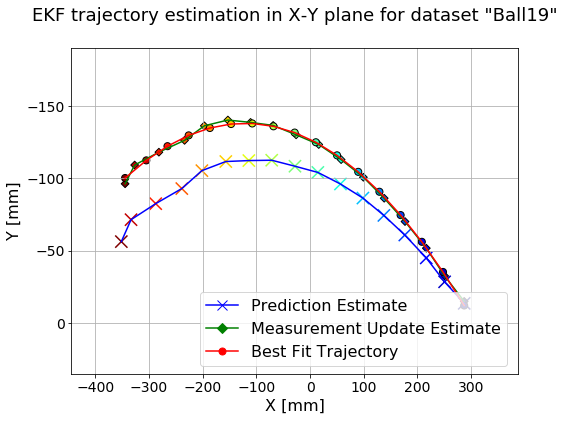

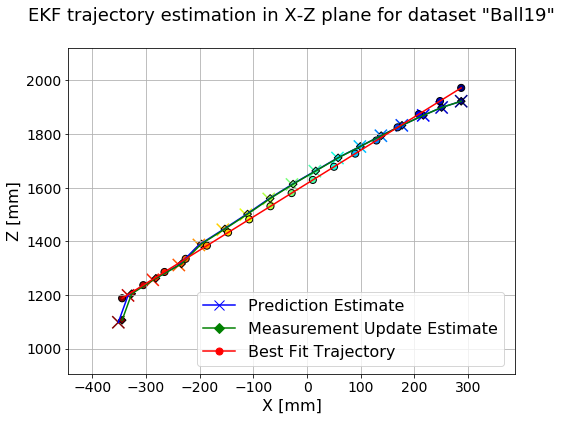

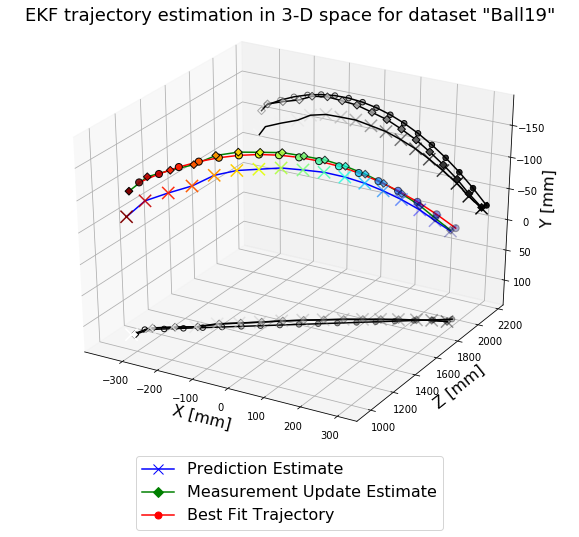

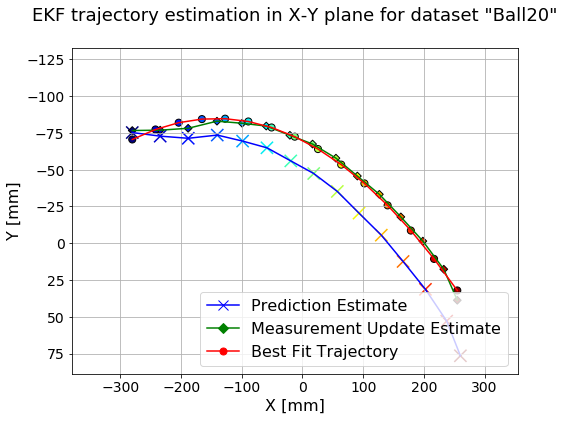

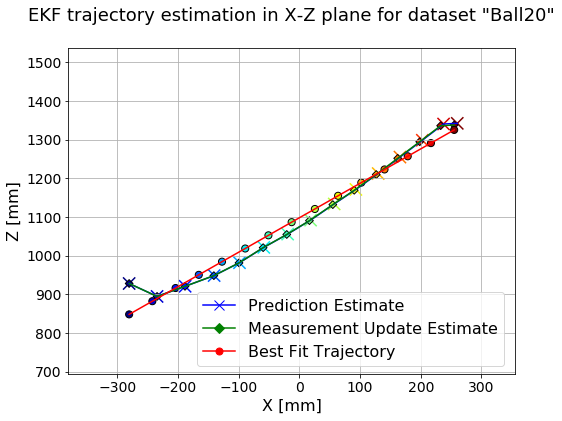

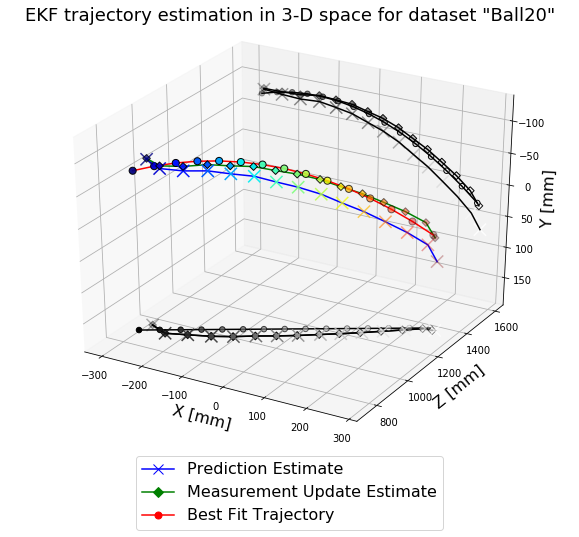

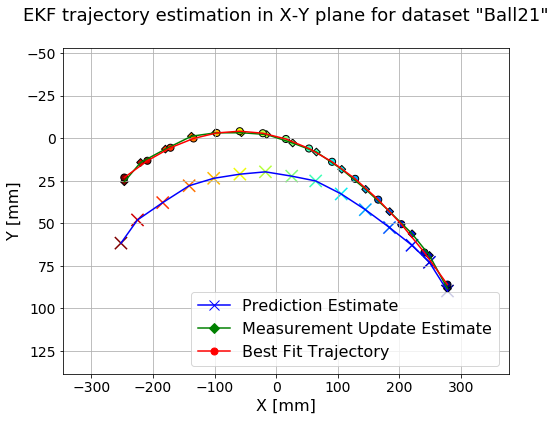

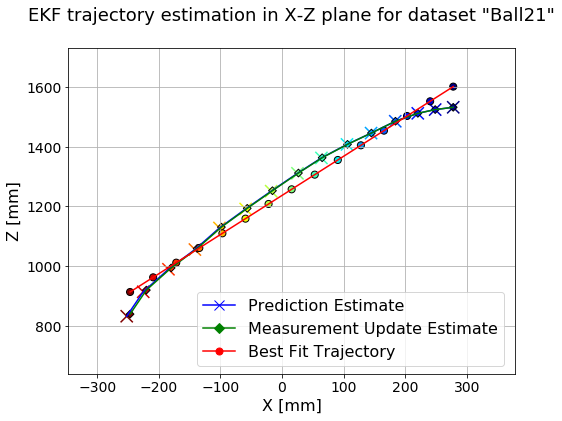

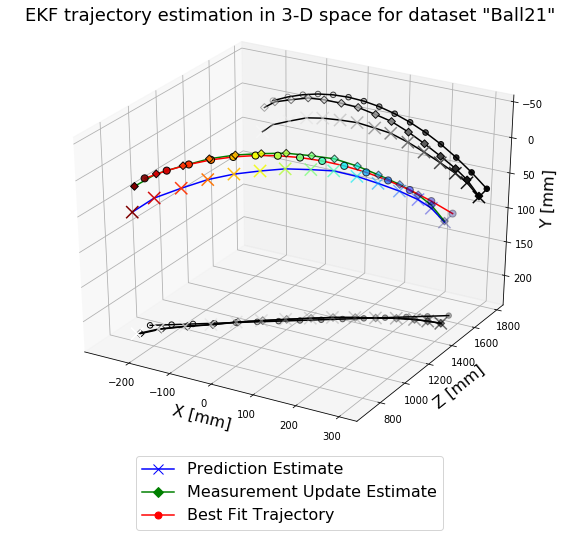

mean predition error:	 37.649837 mm
max predition error:	 130.581967 mm
mean update error:	 25.613072 mm
max update error:	 116.478702 mm


In [137]:
mean_pred = []
mean_up = []
max_pred = []
max_up = []

for i in range(21):
    file = 'Ball%s' %(i+1)
    predict, update = process_video(file, parameters, display=False)
    x_predict, y_predict, z_predict = [], [], []
    x_update, y_update, z_update = [], [], []
    for j in range(len(predict)):
        x_predict.append(predict[j][0,0])
        y_predict.append(predict[j][1,0])
        z_predict.append(predict[j][2,0])
    for j in range(len(update)):
        x_update.append(update[j][0,0])
        y_update.append(update[j][1,0])
        z_update.append(update[j][2,0])
        
    def f(x, A, B):
        return A*x + B
    A, B = curve_fit(f, x_update, z_update)[0]
    x_fit = np.linspace(np.min(x_update), np.max(x_update), len(update))
    if(x_update[0] > 0 ):
        x_fit = np.linspace(np.max(x_update), np.min(x_update), len(update))
    z_fit = A*x_fit + B

    def f(x, A, B, C):
        return A*x**2 + B*x + C
    A, B, C = curve_fit(f, x_update, y_update)[0]
    y_fit = A*x_fit**2 + B*x_fit + C
    
    points_predict, points_update, points_fit = [], [], []
    for i in range(len(x_fit)):
        points_predict.append(np.array(([x_predict[i]], [y_predict[i]], [z_predict[i]])))
        points_update.append(np.array(([x_update[i]], [y_update[i]], [z_update[i]])))
        points_fit.append(np.array(([x_fit[i]], [y_fit[i]], [z_fit[i]])))

    dist_predict, dist_update = [], []
    for i in range(len(points_fit)):
        dist_predict.append(numpy.linalg.norm(points_predict[i] - points_fit[i]))
        dist_update.append(numpy.linalg.norm(points_update[i] - points_fit[i]))

    mean_pred.append(np.mean(dist_predict))
    max_pred.append(np.max(dist_predict))
    mean_up.append(np.mean(dist_update))
    max_up.append(np.max(dist_update))
    
    plot_xy(x_predict, y_predict, x_update, y_update, x_fit, y_fit, file)
    plot_xz(x_predict, z_predict, x_update, z_update, x_fit, z_fit, file)
    plot_3d(x_predict, y_predict, z_predict, x_update, y_update, z_update, x_fit, y_fit, z_fit, file)
    
print('mean predition error:\t %f mm'%np.mean(mean_pred))
print('max predition error:\t %f mm'%np.max(max_pred))
print('mean update error:\t %f mm'%np.mean(mean_up))
print('max update error:\t %f mm'%np.max(max_up))

#### Keys

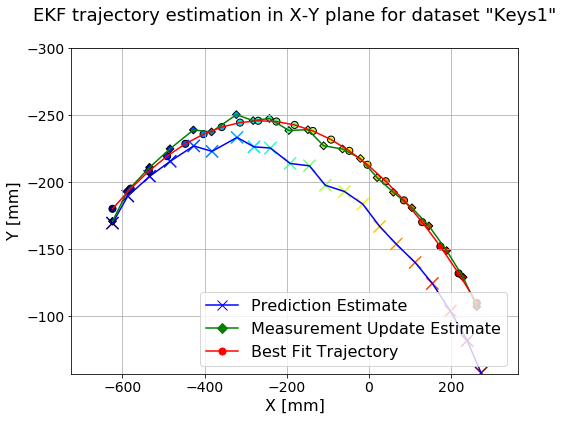

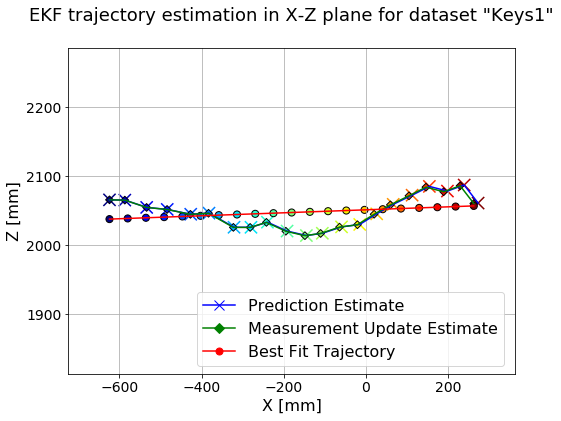

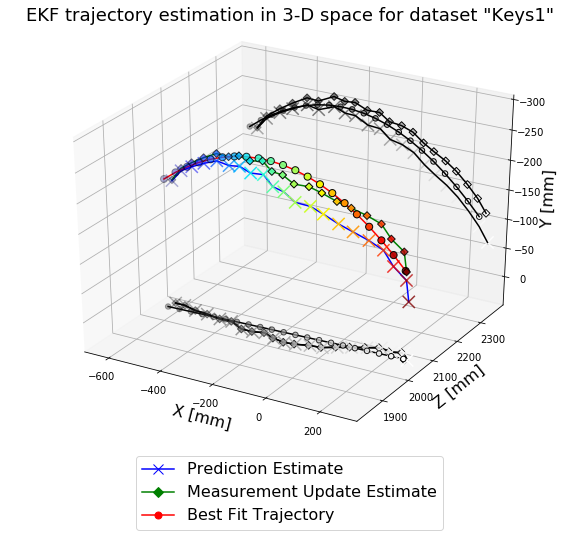

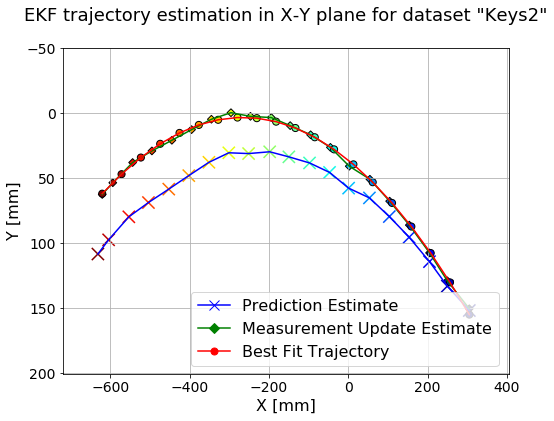

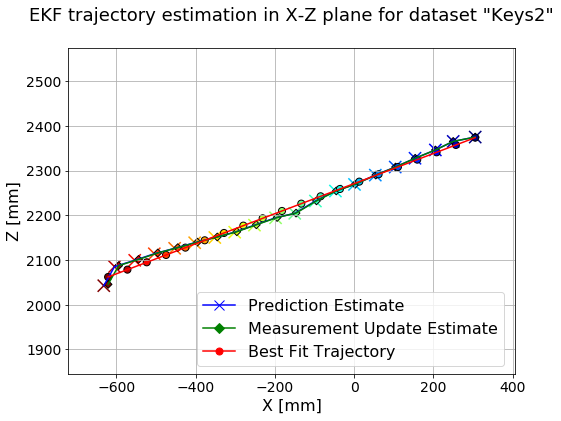

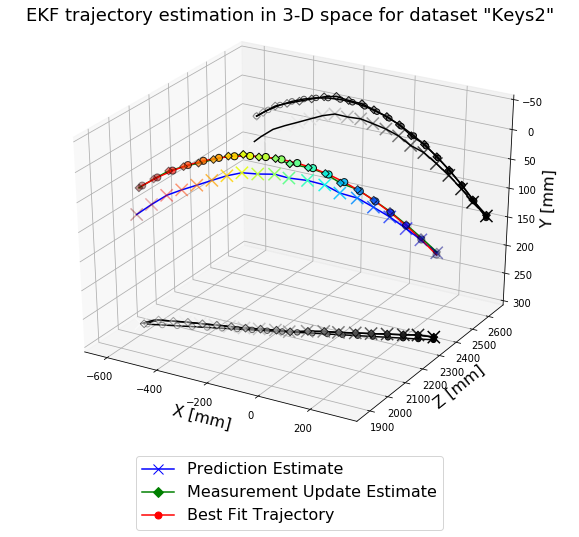

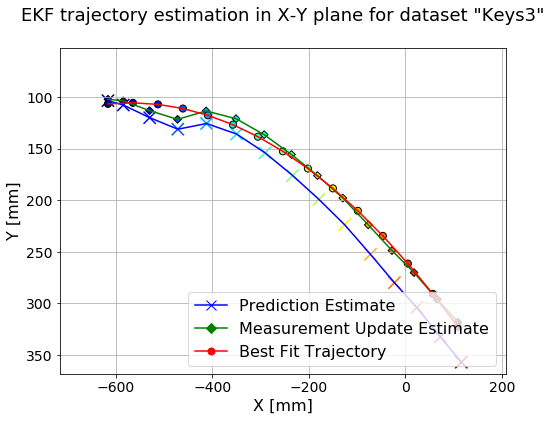

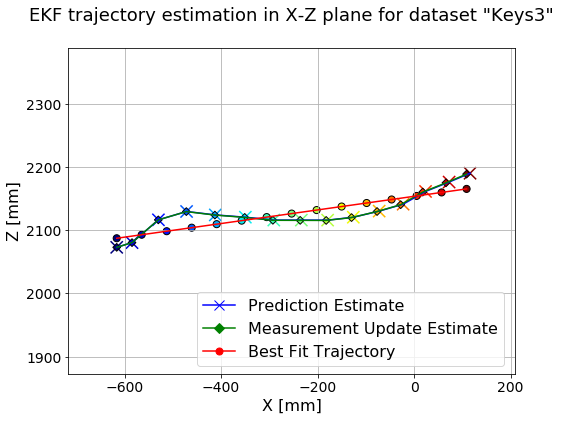

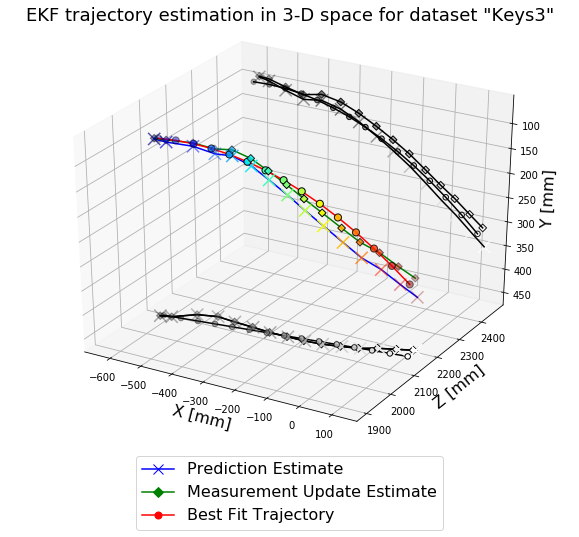

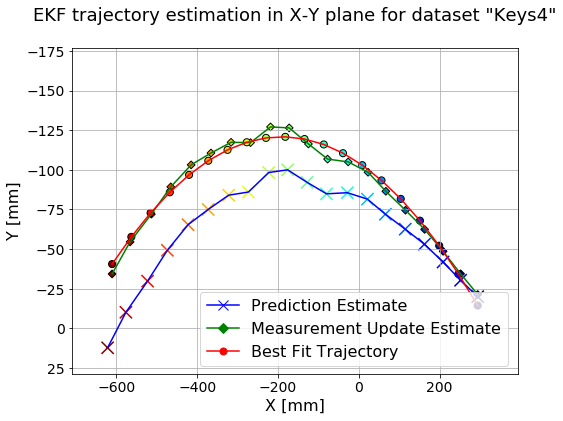

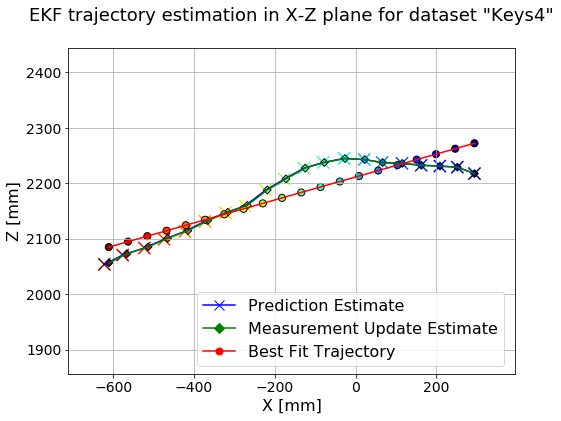

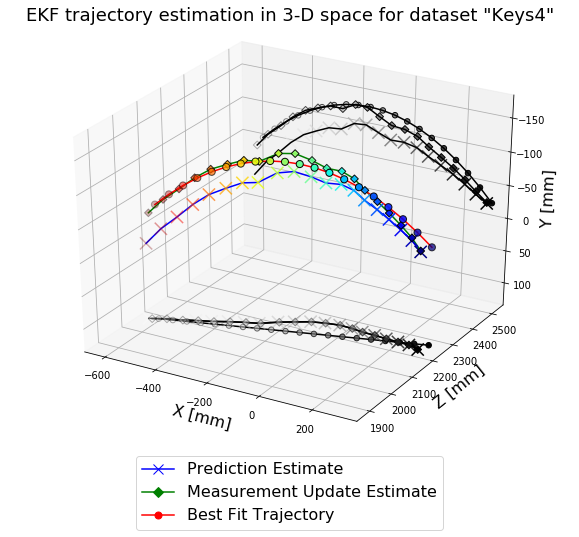

mean predition error:	 37.429038 mm
max predition error:	 62.611398 mm
mean update error:	 23.051401 mm
max update error:	 55.187135 mm


In [138]:
mean_pred = []
mean_up = []
max_pred = []
max_up = []

for i in range(4):
    file = 'Keys%s' %(i+1)
    predict, update = process_video(file, parameters, display=False)
    x_predict, y_predict, z_predict = [], [], []
    x_update, y_update, z_update = [], [], []
    for j in range(len(predict)):
        x_predict.append(predict[j][0,0])
        y_predict.append(predict[j][1,0])
        z_predict.append(predict[j][2,0])
    for j in range(len(update)):
        x_update.append(update[j][0,0])
        y_update.append(update[j][1,0])
        z_update.append(update[j][2,0])
        
    def f(x, A, B):
        return A*x + B
    A, B = curve_fit(f, x_update, z_update)[0]
    x_fit = np.linspace(np.min(x_update), np.max(x_update), len(update))
    if(x_update[0] > 0 ):
        x_fit = np.linspace(np.max(x_update), np.min(x_update), len(update))
    z_fit = A*x_fit + B

    def f(x, A, B, C):
        return A*x**2 + B*x + C
    A, B, C = curve_fit(f, x_update, y_update)[0]
    y_fit = A*x_fit**2 + B*x_fit + C
    
    points_predict, points_update, points_fit = [], [], []
    for i in range(len(x_fit)):
        points_predict.append(np.array(([x_predict[i]], [y_predict[i]], [z_predict[i]])))
        points_update.append(np.array(([x_update[i]], [y_update[i]], [z_update[i]])))
        points_fit.append(np.array(([x_fit[i]], [y_fit[i]], [z_fit[i]])))

    dist_predict, dist_update = [], []
    for i in range(len(points_fit)):
        dist_predict.append(numpy.linalg.norm(points_predict[i] - points_fit[i]))
        dist_update.append(numpy.linalg.norm(points_update[i] - points_fit[i]))

    mean_pred.append(np.mean(dist_predict))
    max_pred.append(np.max(dist_predict))
    mean_up.append(np.mean(dist_update))
    max_up.append(np.max(dist_update))
    
    plot_xy(x_predict, y_predict, x_update, y_update, x_fit, y_fit, file)
    plot_xz(x_predict, z_predict, x_update, z_update, x_fit, z_fit, file)
    plot_3d(x_predict, y_predict, z_predict, x_update, y_update, z_update, x_fit, y_fit, z_fit, file)
    
print('mean predition error:\t %f mm'%np.mean(mean_pred))
print('max predition error:\t %f mm'%np.max(max_pred))
print('mean update error:\t %f mm'%np.mean(mean_up))
print('max update error:\t %f mm'%np.max(max_up))

#### Pen

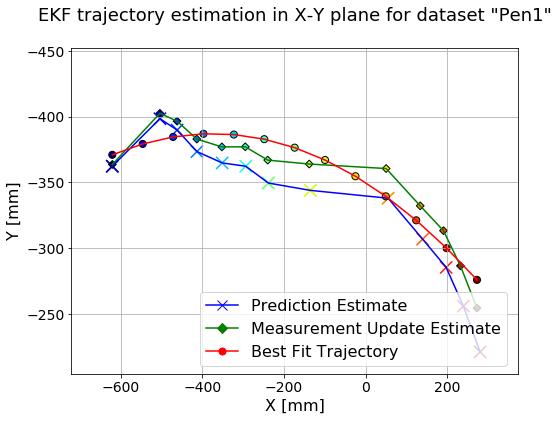

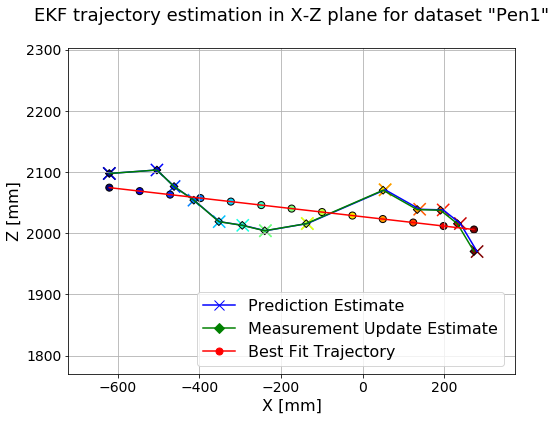

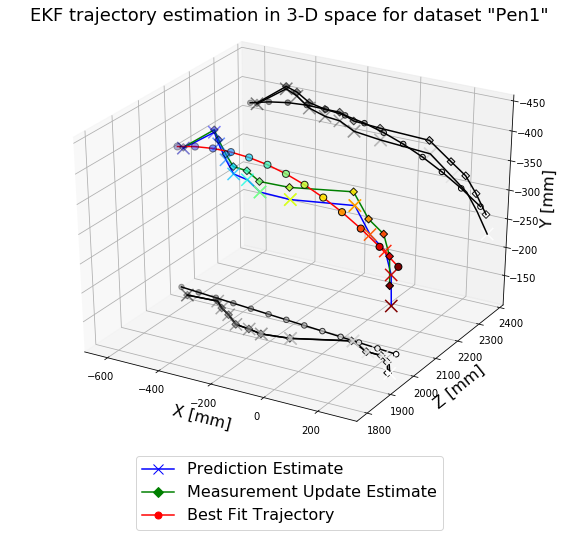

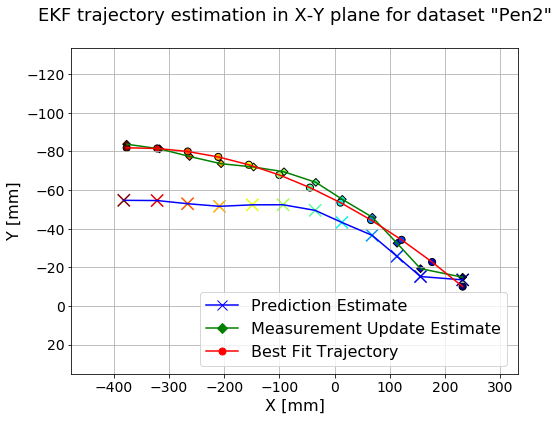

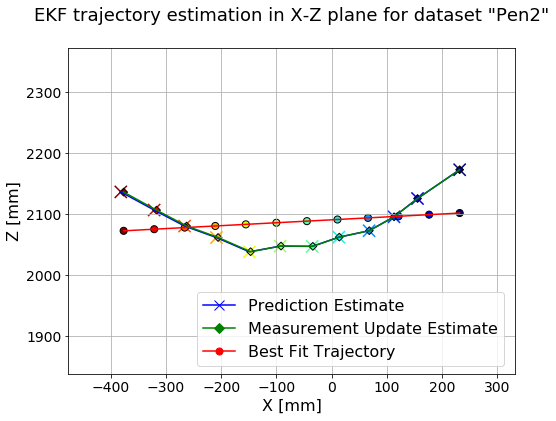

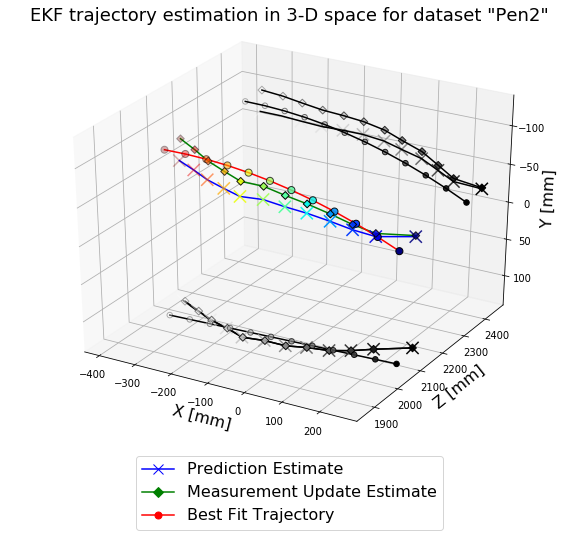

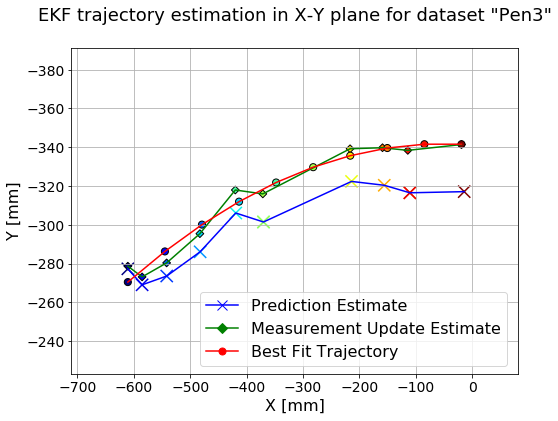

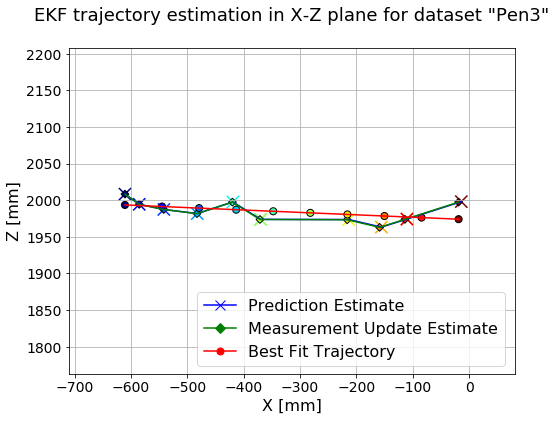

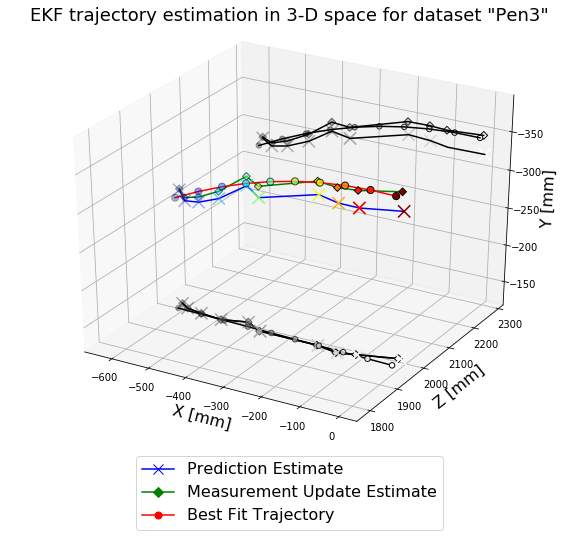

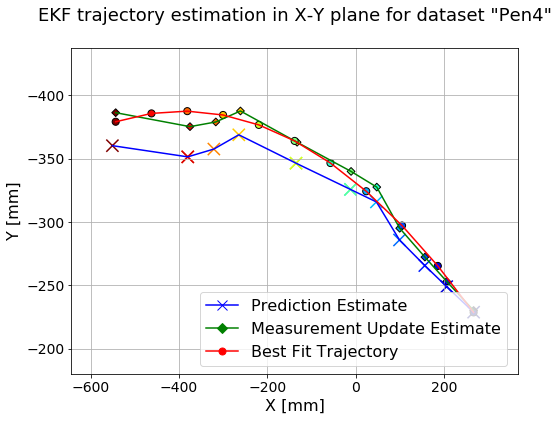

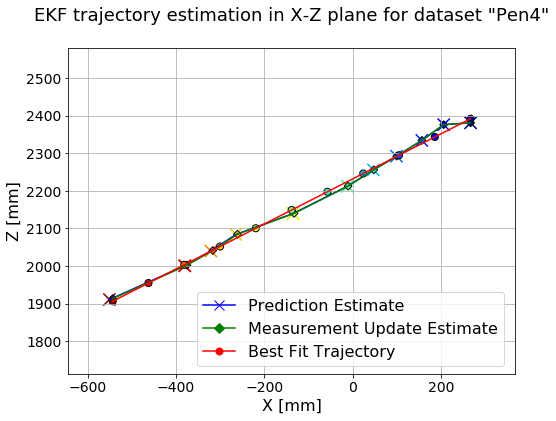

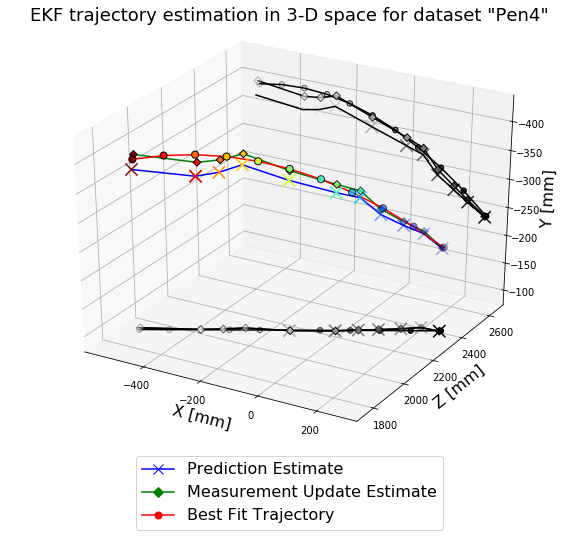

mean predition error:	 101.305141 mm
max predition error:	 284.043835 mm
mean update error:	 50.778288 mm
max update error:	 144.492536 mm


In [139]:
mean_pred = []
mean_up = []
max_pred = []
max_up = []

for i in range(4):
    file = 'Pen%s' %(i+1)
    predict, update = process_video(file, parameters, display=False)
    x_predict, y_predict, z_predict = [], [], []
    x_update, y_update, z_update = [], [], []
    for j in range(len(predict)):
        x_predict.append(predict[j][0,0])
        y_predict.append(predict[j][1,0])
        z_predict.append(predict[j][2,0])
    for j in range(len(update)):
        x_update.append(update[j][0,0])
        y_update.append(update[j][1,0])
        z_update.append(update[j][2,0])
        
    def f(x, A, B):
        return A*x + B
    A, B = curve_fit(f, x_update, z_update)[0]
    x_fit = np.linspace(np.min(x_update), np.max(x_update), len(update))
    if(x_update[0] > 0 ):
        x_fit = np.linspace(np.max(x_update), np.min(x_update), len(update))
    z_fit = A*x_fit + B

    def f(x, A, B, C):
        return A*x**2 + B*x + C
    A, B, C = curve_fit(f, x_update, y_update)[0]
    y_fit = A*x_fit**2 + B*x_fit + C
    
    points_predict, points_update, points_fit = [], [], []
    for i in range(len(x_fit)):
        points_predict.append(np.array(([x_predict[i]], [y_predict[i]], [z_predict[i]])))
        points_update.append(np.array(([x_update[i]], [y_update[i]], [z_update[i]])))
        points_fit.append(np.array(([x_fit[i]], [y_fit[i]], [z_fit[i]])))

    dist_predict, dist_update = [], []
    for i in range(len(points_fit)):
        dist_predict.append(numpy.linalg.norm(points_predict[i] - points_fit[i]))
        dist_update.append(numpy.linalg.norm(points_update[i] - points_fit[i]))

    mean_pred.append(np.mean(dist_predict))
    max_pred.append(np.max(dist_predict))
    mean_up.append(np.mean(dist_update))
    max_up.append(np.max(dist_update))
    
    plot_xy(x_predict, y_predict, x_update, y_update, x_fit, y_fit, file)
    plot_xz(x_predict, z_predict, x_update, z_update, x_fit, z_fit, file)
    plot_3d(x_predict, y_predict, z_predict, x_update, y_update, z_update, x_fit, y_fit, z_fit, file)
    
print('mean predition error:\t %f mm'%np.mean(mean_pred))
print('max predition error:\t %f mm'%np.max(max_pred))
print('mean update error:\t %f mm'%np.mean(mean_up))
print('max update error:\t %f mm'%np.max(max_up))

#### Wallet

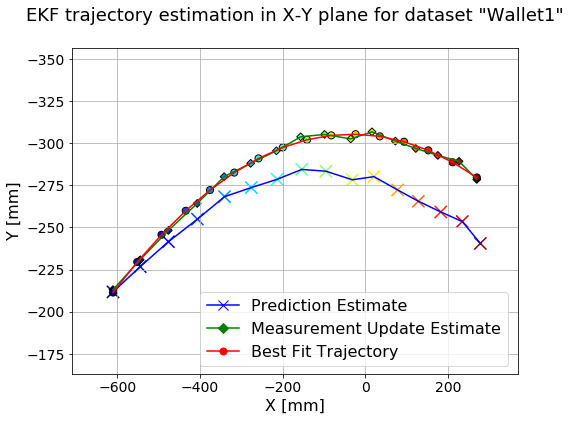

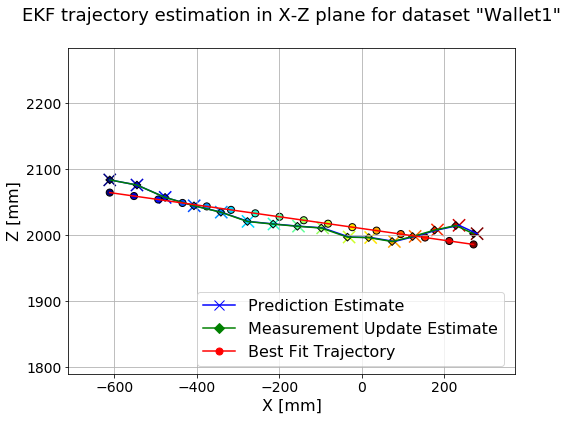

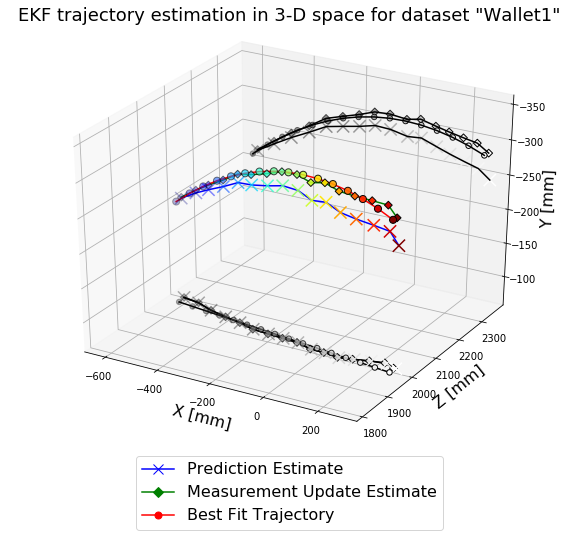

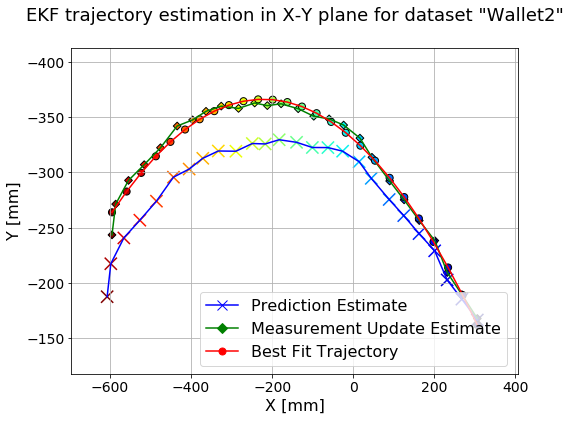

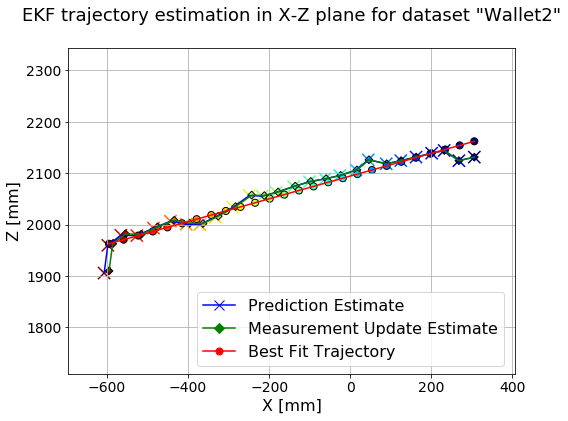

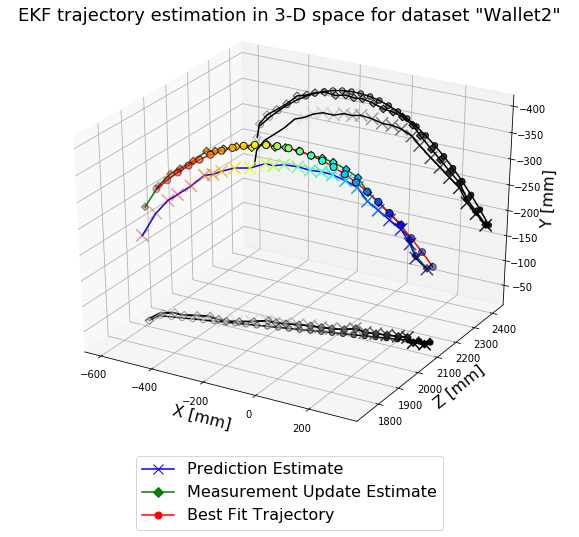

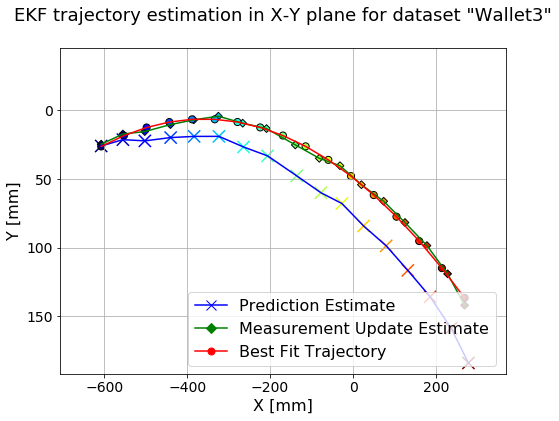

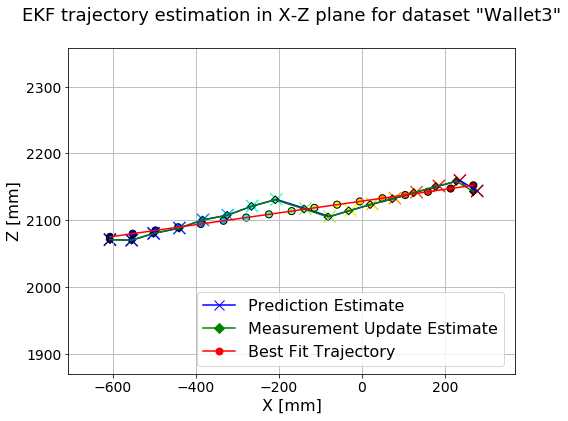

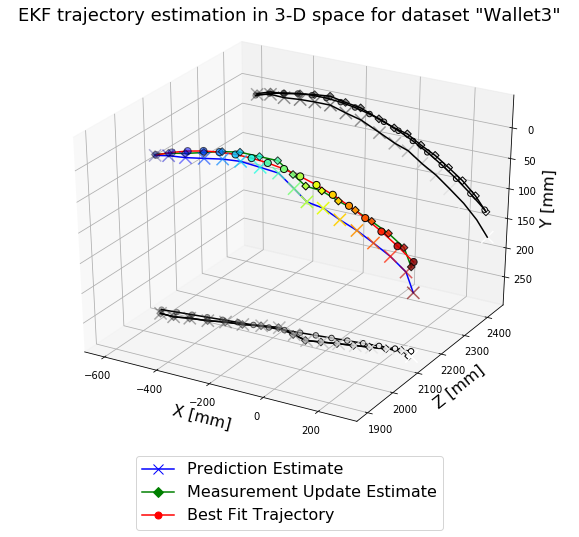

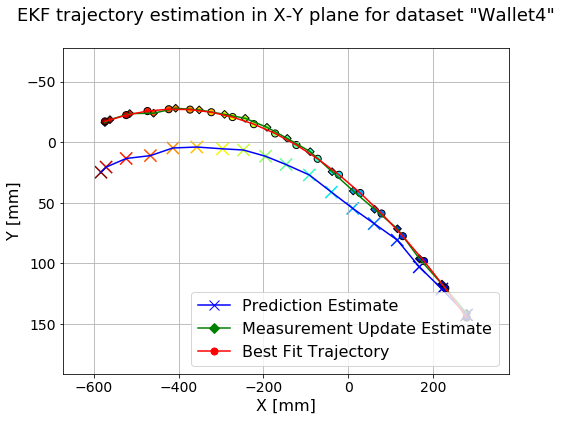

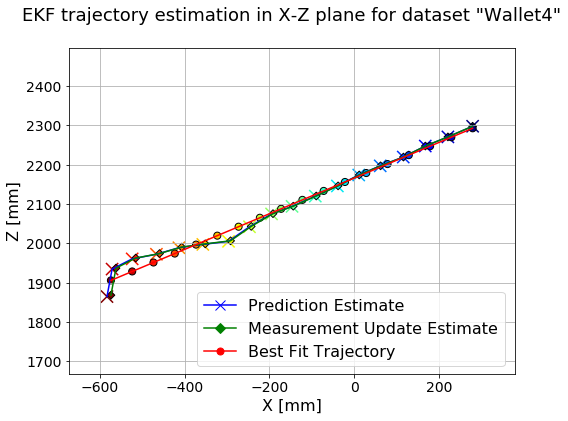

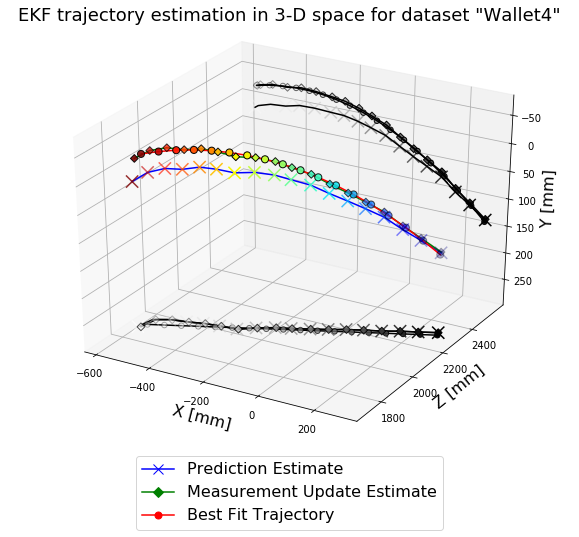

mean predition error:	 38.015852 mm
max predition error:	 95.923829 mm
mean update error:	 24.031882 mm
max update error:	 56.681003 mm


In [140]:
mean_pred = []
mean_up = []
max_pred = []
max_up = []

for i in range(4):
    file = 'Wallet%s' %(i+1)
    predict, update = process_video(file, parameters, display=False)
    x_predict, y_predict, z_predict = [], [], []
    x_update, y_update, z_update = [], [], []
    for j in range(len(predict)):
        x_predict.append(predict[j][0,0])
        y_predict.append(predict[j][1,0])
        z_predict.append(predict[j][2,0])
    for j in range(len(update)):
        x_update.append(update[j][0,0])
        y_update.append(update[j][1,0])
        z_update.append(update[j][2,0])
        
    def f(x, A, B):
        return A*x + B
    A, B = curve_fit(f, x_update, z_update)[0]
    x_fit = np.linspace(np.min(x_update), np.max(x_update), len(update))
    if(x_update[0] > 0 ):
        x_fit = np.linspace(np.max(x_update), np.min(x_update), len(update))
    z_fit = A*x_fit + B

    def f(x, A, B, C):
        return A*x**2 + B*x + C
    A, B, C = curve_fit(f, x_update, y_update)[0]
    y_fit = A*x_fit**2 + B*x_fit + C
    
    points_predict, points_update, points_fit = [], [], []
    for i in range(len(x_fit)):
        points_predict.append(np.array(([x_predict[i]], [y_predict[i]], [z_predict[i]])))
        points_update.append(np.array(([x_update[i]], [y_update[i]], [z_update[i]])))
        points_fit.append(np.array(([x_fit[i]], [y_fit[i]], [z_fit[i]])))

    dist_predict, dist_update = [], []
    for i in range(len(points_fit)):
        dist_predict.append(numpy.linalg.norm(points_predict[i] - points_fit[i]))
        dist_update.append(numpy.linalg.norm(points_update[i] - points_fit[i]))

    mean_pred.append(np.mean(dist_predict))
    max_pred.append(np.max(dist_predict))
    mean_up.append(np.mean(dist_update))
    max_up.append(np.max(dist_update))
    
    plot_xy(x_predict, y_predict, x_update, y_update, x_fit, y_fit, file)
    plot_xz(x_predict, z_predict, x_update, z_update, x_fit, z_fit, file)
    plot_3d(x_predict, y_predict, z_predict, x_update, y_update, z_update, x_fit, y_fit, z_fit, file)
    
print('mean predition error:\t %f mm'%np.mean(mean_pred))
print('max predition error:\t %f mm'%np.max(max_pred))
print('mean update error:\t %f mm'%np.mean(mean_up))
print('max update error:\t %f mm'%np.max(max_up))